In [705]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

import time as time

plt.rcParams["figure.figsize"] = (20,10)

In [706]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [707]:
"""
Находит градиент функции fun в точке x с точностью h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Находит "частичный" градиент функции, представленный в виде суммы.
Вычисляет сумму производных некоторых аргументов функции fun подряд.

@param fun: список аргументов функции для которых находим частичный градиент
@param x: точка, в которой вычисляются производные
@param r: массив 2 элементов: 
    1 элемент показывает первый аргумент в списке fun, для которого будет найден градиент.
    2 элемент показывает, для скольких аргументов после первого будет найден градиент.
@param h: точность вычисленных градиентов

@returns r[1] список, содержащий сумму вычисленных градиентов

"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Генерирует датасет для множественной линейной регрессии.
Гарантируется, что ожидаемое значение шума равно 0. 
Каждый регрессор представляет собой len(b) - 1-мерный вектор.
Как списки регрессоров, так и списки зависимых переменных имеют размер, равный size.
Для понимания мы можем сказать, что функция генерирует точки,
сдвинутые вверх или вниз относительно некоторой гиперплоскости.

b[1:] - задает в некотором роде нормаль к этой гиперполскости.
b[0] - смещение гиперплоскости вверх или вниз относительно начала координат
length - длина гиперплоскости.
k - шум, который характеризует, насколько сгенерированные точки будут отклоняться от гиперплоскости, 
которую мы аппроксимируем.
size - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.

@param b:список, характеризующий линейную зависимость между:
регрессорами (независимыми переменными) и зависимой переменной.
b[0] - смещение зависимой переменной

@param k: шум (аргумент ошибки) максимальное абсолютное значение
@param size: количество точек (экземпляров данных) в датасете
@param r: кортеж, описывающий диапазон, в котором будут сгенерированы регрессоры (функция)

@return список из двух элементов: список регрессоров и список зависимых значений
"""
def generate_dataset(b:List[float], k:int, size:int=50, r:tuple = (0, 10)) -> List[List[float]]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = np.random.rand(size, dim) * (r[1] - r[0]) + r[0]
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = np.sum(b * regressors, axis=1) + h + e
    return [regressors, dependent_var]

"""
Генерирует функцию, минимальная точка которой является решением задачи линейной регрессии для датасета [t, ft].
Довольно времязатратный процесс.


@param t: список регрессоров
@param ft: список зависимых значений

@возвращает список аргументов сгенерированной функции
(каждый аргумент представляет расстояние от свернутой функции до одной точки из датасета)
"""
def generate_minimized_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l,
                             a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
        # or
        # sum_fun[i] = partial(lambda t, ft, l,
        #a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Генерирует функцию, минимальная точка которой является решением задачи линейной регрессии для датасета [t, ft].
Аналогично generate_minimized_fun, но каждый регрессор является 1-мерным вектором
(т.е. Минимизированная функция имеет два аргумента). 
Используется эта функция только тогда, когда необходимо построить минимизированную функцию. 

Функция, сгенерированная generate_minimized_two_variable_fun, отлично работает, когда аргументы являются массивами,
в отличие от generate_minimized_fun.

@param t: список регрессоров
@param ft: список зависимых значений

@возвращает список аргументов сгенерированной функции
(каждый аргумент представляет расстояние от сгенерированной функции до одной точки из набора данных)
"""
def generate_minimized_two_variable_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + a[1] * t - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Генерирует функцию из аргументов.
Каждый аргумент - это функция. 
Каждая функция из аргументов должна принимать равное количество параметров.

@return функция, представляющая сумму функций из терминов

"""
def fun_from_terms(terms:List[Callable[[List[float]], float]]) -> Callable[[List[float]], float]:
    return reduce(lambda f1, f2: lambda x: f1(x) + f2(x), terms)

class StandartScaler:
    """
    Предлагает функциональность для выполнения стандартного масштабирования.
    Идеально работает, когда данные генерируются функцией generate_dataset.
    @param t: список экземпляров данных для которых вычисляем среднее значение и отклонение

    """
    def __init__(self, t:ndarray):
        self.mean = np.mean(t, axis=0)
        self.deviation = np.std(t, axis=0)

    """
    Масштабирует объекты (регрессоры) в экземплярах данных. 
    Среднее значение и стандартное отклонение после масштабирования равны 0 и 1 соответственно.
    
    @param t: список экземпляров данных
    @return список экземпляров данных с масштабируемыми объектами
    """
    def scale(self, t:ndarray) -> ndarray:
        return (t - self.mean) / self.deviation

    """
    Выполнение обратного масштабирования.

    @param t: список масштабируемых экземпляров данных
    @return список экземпляров данных перед масштабированием

    """
    def scale_reverse(self, t:ndarray) -> ndarray:
        return t * self.deviation + self.mean

    """
    Вычисляет минимальную точку функции с немасштабированными экземплярами данных,
    используя минимальную точку функции с масштабированными экземплярами данных.

    @param min_point: масштабированная минимальная точка
    @return начальная минимальная точка
    """
    def reverse_min_point(self, min_point:ndarray) -> ndarray:
        return np.concatenate([min_point[0] - min_point[1:] * self.mean / self.deviation,
                               min_point[1:] / self.deviation])

"""
!Устарел!
Масштабирует объекты (регрессоры) в экземплярах данных. 
Каждое значение объекта находится в диапазоне [r[0], r[1]] после масштабирования.
Поскольку набор данных, возвращаемый из generate_dataset, обычно распределяется внутри каждого объекта,
лучше НЕ использовать этот масштаб, если датасет сгенерирован с помощью generate_dataset.

@param t: список экземпляров данных
@return список экземпляров данных с масштабируемыми объектами
"""
def min_max_scale(t, r=(0, 1)):
    return (t - np.min(t, axis=0)) / (np.max(t, axis=0) - np.min(t, axis=0)) * (r[1] - r[0]) + r[0]

"""
Строит линии уровня двух переменных функций, представленных терминами.

@param terms: список аргументов построенной функции (должен быть результатом generate_minimized_two_variable_fun)
@param points: список точек, в которых строятся линии уровня
@param offset: характеризует масштаб графика

"""
def plot_path_contours(terms:List[Callable[[List[float]], float]],
                       points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-', color = "red")
    color_line = np.zeros((10, 3))
    color_line[:, 1:] = 0.7
    color_line[:, 0] = np.linspace(0, 1, 10)
    fun = fun_from_terms(terms)
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('SGD path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])), colors = color_line)

"""
Строит 2-мерный график линейной функции с двумя переменными, представленной fun_coeffs. 
fun_coeffs[0] представляет смещение высоты.
"""
def plot_dataset_and_function(t:List[List[float]], ft:List[float], fun_coeffs:List[float]) -> None:
    ax = plt.figure().add_subplot()
    ax.plot(t, ft, 'o', markersize=1)
    tt = np.linspace(np.min(t), np.max(t), 1000)
    plt.title('Data set and evaluated function', fontsize=22)
    ax.plot(tt, fun_coeffs[1] * tt + fun_coeffs[0])

"""
Показывает, как SGD приближается к минимальной точке вдоль каждой координаты
"""
def plot_convergence(points:ndarray) -> None:
    ax = plt.figure().add_subplot()
    plt.title('Convergence plot', fontsize=22)
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

"""
Выводит данные, описывающие эффективность SGD.

@param actual_min: реальная минимальная точка вычисляемой функции
@param point: путь SGD
"""
def print_result(actual_min:ndarray, points:ndarray, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Iterations: {len(points)}')
    print(f'Path: {points}')

"""
Находит минимум функции sum_fun с использованием стохастического градиентного спуска (sgd).

@param sum_fun: функция в виде списка аргументов для которых ищем минмимум
@param x: точка начала поиска минимума
@param max_epoch: верхняя граница для количества итераций
(если параметр stop_criteria имеет дефолтное значение, то количество итераций равно max_epoch)
@param batch_size: количество аргументов sum_fun для поиска градиента на каждой итерации
@param lr: начальное значение скорости обучения (показывает, насколько большими будут шаги на каждой итерации)
@param scheduler: как скорость обучения будет меняться во время итераций 
(когда скорость обучения по умолчанию постоянна)
@param stop_criteria: альтернатива критерию остановки max_epoch (когда значение по умолчанию никогда не выполняется)
@return список точек, представляющих путь SGD. Последняя точка списка - это найденная минимальная точка.
Количество точек представляет количество эпох до тех пор,
пока не будут выполнены критерии остановки или не будет достигнут max_epoch

"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float],
        scheduler:Callable[[List[float]], float]=lambda lr: lr,
        stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points.append(x)
    return np.array(points)

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

Precision: [0.79852924 0.00266118]
Min point: [ 9.20147076 -4.00266118]
Iterations: 50
Path: [[ 0.          0.        ]
 [ 0.96586862 -1.17330303]
 [ 2.93237569 -2.05980098]
 [ 3.51695238 -2.54245192]
 [ 4.58670857 -2.95980787]
 [ 5.53850299 -3.32280651]
 [ 6.03015222 -3.45395001]
 [ 6.64386949 -3.59957805]
 [ 6.55750818 -3.6900158 ]
 [ 7.35235708 -3.8775436 ]
 [ 8.08728044 -3.73025511]
 [ 8.19607432 -3.76809547]
 [ 8.25610891 -3.89512448]
 [ 8.33247176 -4.02136792]
 [ 8.72054918 -4.00548457]
 [ 8.90243006 -4.05384643]
 [ 9.03470589 -4.01435872]
 [ 9.29449827 -4.03203199]
 [ 9.15121215 -4.08022574]
 [ 9.02670901 -4.0813023 ]
 [ 9.39087672 -4.15767454]
 [ 9.42720805 -4.15576444]
 [ 9.59263853 -3.96305689]
 [ 9.88228759 -4.01164382]
 [ 9.81098211 -4.03492236]
 [ 9.79637074 -4.06388878]
 [ 9.86582657 -3.90756132]
 [ 9.72347527 -3.95239563]
 [ 9.8695404  -3.9896745 ]
 [ 9.80343796 -4.03161511]
 [ 9.7379151  -4.03749797]
 [ 9.46175163 -4.05135844]
 [ 9.30858131 -4.08302653]
 [ 9.16558041 -4

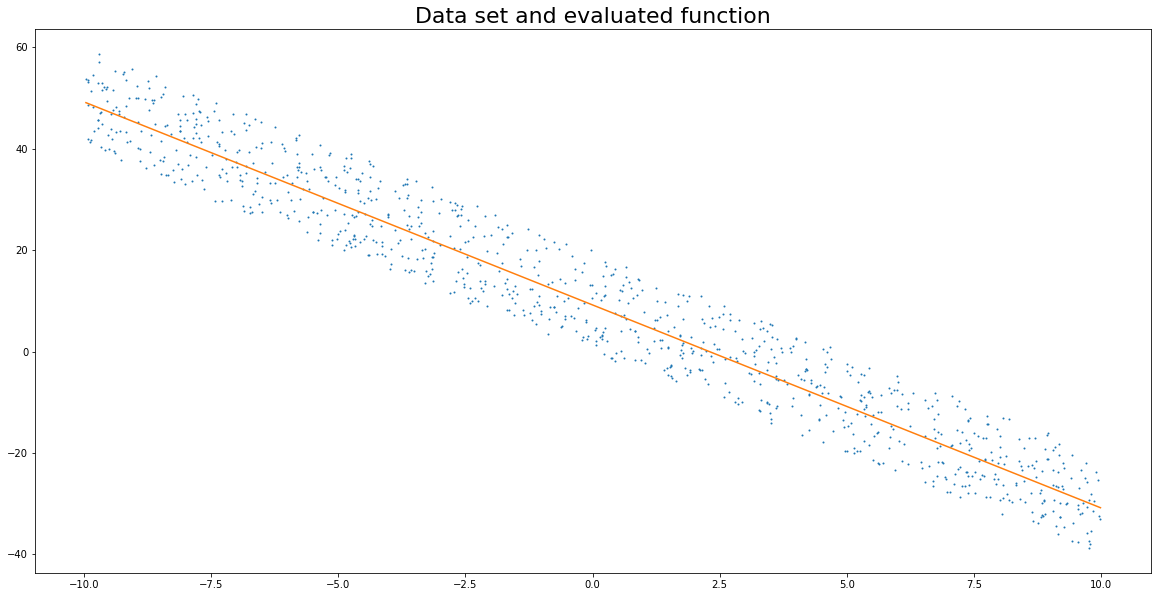

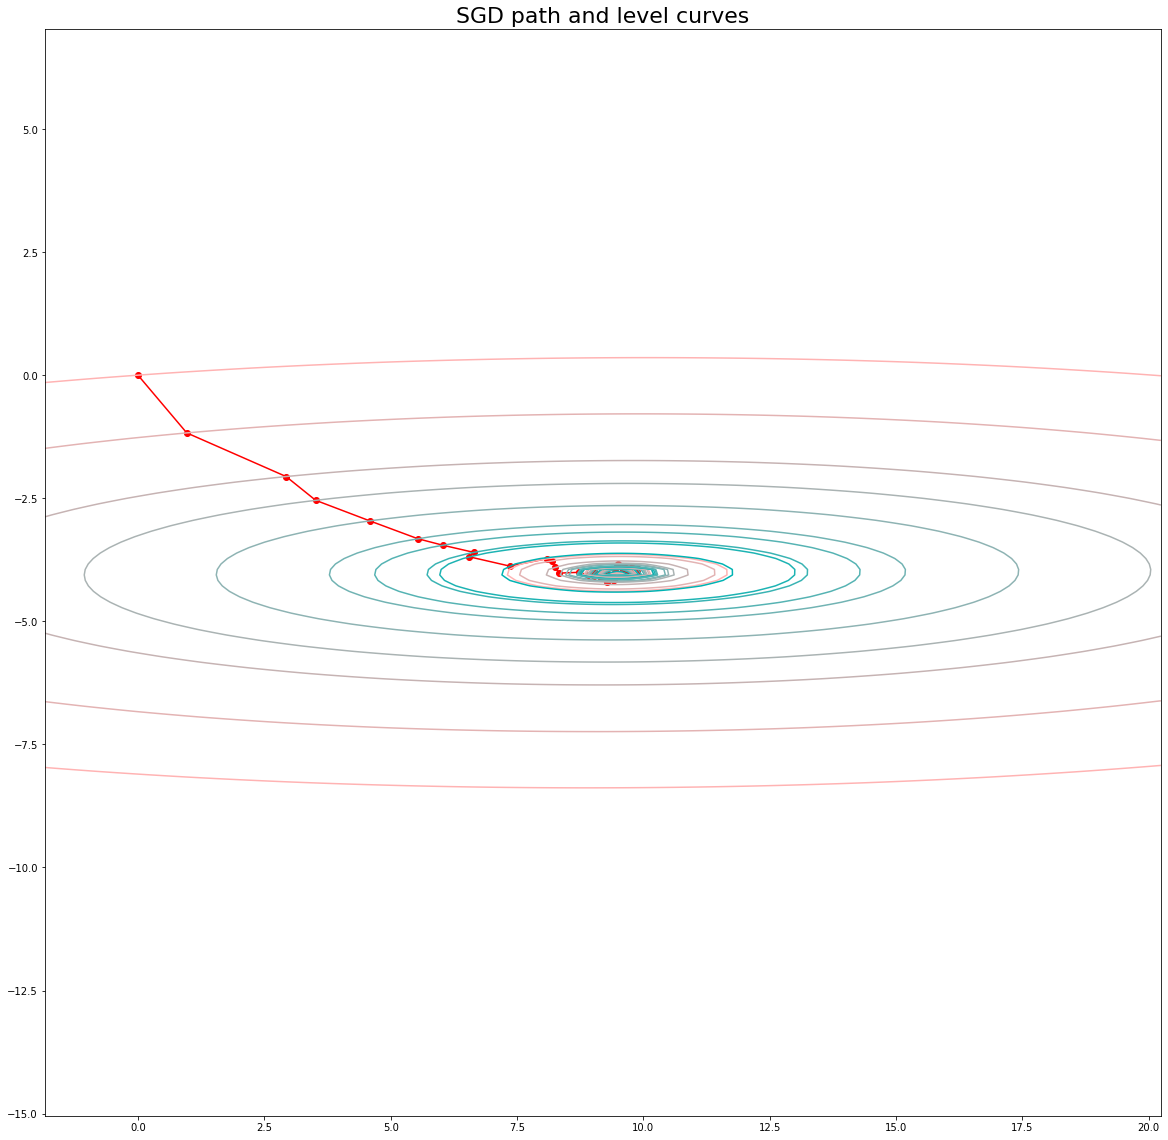

In [708]:
a = [10, -4]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 50
batch_size = 20
lr = [150, 8]

points = sgd(sum_fun, x, epoch, batch_size, lr, stop_criteria=lambda x: (np.abs(x - a) < 0.05).all())

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

Precision: [-0.00104547 -0.08991121  0.01914037]
Min point: [10.00104547  2.08991121  3.98085963]
Iterations: 50
Path: [[ 0.          0.          0.        ]
 [ 2.27266271  0.5243606   2.066692  ]
 [ 3.2914576   0.7321789   2.72695617]
 [ 4.32594013  0.90031218  3.08889325]
 [ 5.24477199  1.09180571  3.28881495]
 [ 5.86084836  1.15583579  3.59597276]
 [ 6.61769196  1.26480235  3.83084685]
 [ 6.91382072  1.33859767  3.70120024]
 [ 7.10380815  1.50557059  3.74378707]
 [ 7.43433964  1.5672215   3.72170577]
 [ 7.85867387  1.66976869  3.75855967]
 [ 8.01785585  1.64084627  3.84666404]
 [ 8.1143111   1.66502739  3.8609965 ]
 [ 8.58480254  1.769178    4.09109601]
 [ 8.91221869  1.73494756  4.08642096]
 [ 9.25952054  1.8463398   4.19779891]
 [ 9.47047228  1.89891798  4.20954996]
 [ 9.42198159  1.90348533  4.16068567]
 [ 9.56015561  1.92848628  4.09891426]
 [ 9.65307432  1.93041052  4.06478167]
 [ 9.61542739  1.9506629   4.01511404]
 [ 9.65219797  1.92586883  3.99678039]
 [ 9.93352543  1.907069

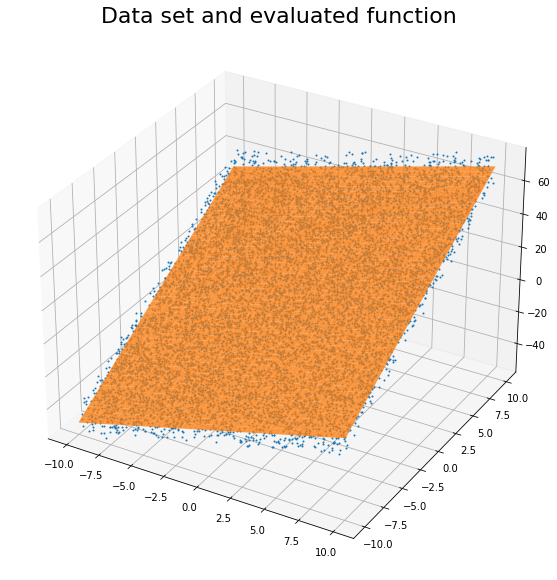

In [709]:
a = [10, 2, 4]
t, ft = generate_dataset(a, 10, 10000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print_result(a, points)
ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
plt.title('Data set and evaluated function', fontsize=22)
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
tt = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [710]:
a = [10, 2, 4, 5, -3]
t, ft = generate_dataset(a, 10, 100000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [ 0.21428793  0.2181485   0.39901551  0.1019059  -0.37849898]
Min point: [ 9.78571207  1.7818515   3.60098449  4.8980941  -2.62150102]
Iterations: 50
Path: [[ 0.          0.          0.          0.          0.        ]
 [-2.66580522 -0.06474041  0.15318386  0.38963577 -0.11581588]
 [ 0.7727755   0.55775851  0.56649949  1.29342416 -0.43268909]
 [ 1.22558689  0.55646622  0.69902228  1.7086079  -0.40583853]
 [ 1.80812693  0.75885377  0.81090156  2.01727522 -0.48508018]
 [ 1.22328606  0.91121096  1.04699249  2.30575828 -0.61492198]
 [ 2.6462483   0.90560998  1.2314687   2.68133739 -0.60398123]
 [ 5.00943097  1.32086189  1.63666904  3.29892474 -0.94435324]
 [ 6.05017519  1.3307991   1.71755961  3.41246296 -0.94882151]
 [ 6.97835536  1.38709307  1.750987    3.58423408 -0.97465196]
 [ 8.22992738  1.40381402  1.91312679  3.71413918 -1.07741827]
 [ 9.04050193  1.24803188  2.14384853  3.95089476 -1.22108079]
 [ 9.87638239  1.25828472  2.14297064  4.00199348 -1.25999919]
 [ 9.50371318 

## 100-мерное пространство регрессоров

In [711]:
n = 101
a = np.random.randint(-10, 10, n)
t, ft = generate_dataset(a, 10, 1000000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(n)
epoch = 50
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [-10.0604957   -5.75134787  -5.88178095  -8.40935702  -2.69351432
  -4.45298949  -6.47812089   1.69783594  -4.24134244   3.35147376
   3.25636826  -5.56115614  -0.18041074   1.59639781   2.93107257
   3.70807992  -8.35384525  -7.83503137   2.92613742   1.78652899
   1.97069408   2.46759943  -6.40733572   3.93667283   2.28764031
   4.22878557   4.9578739    7.19758248   7.52135884   7.47590341
  -6.00490414  -6.73689191  -1.20658071  -4.70133858  -0.29220909
  -3.1863318   -0.94498261   4.05474202   7.6795092    5.0022397
   6.55719805   1.0472938    7.41162057  -0.68817663  -2.78016871
  -8.25635078  -3.32462199  -7.85496549  -1.56425238  -5.85561032
  -5.78494599  -2.46777465  -2.39699903  -3.38007051   3.5253096
  -1.67049603   4.56269278  -3.33164024  -8.56205858   0.79530831
  -0.24442769   7.12237103   4.96674115  -0.04610151  -2.46384508
   6.08796628  -5.18339039  -8.86308737  -4.3597265   -3.1059128
   6.80995996  -5.77740355   5.44458356   4.899459     1.22831256
  

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров. Можно заметить, что с повышением размера batch графики отклонений становятся всё плавнее, стремясь к некоторой точке, близкой к нулю.

[[-0.52558106 -0.37494236  0.84766673]
 [ 1.39306491 -0.15670663  0.15273043]
 [ 0.08889537 -0.05207196 -0.08549064]
 [ 1.31937312 -0.19196055  0.14790788]
 [ 0.41611147 -0.01981539 -0.13967166]
 [ 1.07400566 -0.16462532  0.15006901]
 [ 0.70878217  0.02837918 -0.08999964]
 [ 0.92095391 -0.12509877  0.05526417]
 [ 0.79186105  0.04024962 -0.04459156]
 [ 0.85940988 -0.12635727  0.01173012]
 [ 0.95154306  0.01342605 -0.10866372]
 [ 0.90332082 -0.07438103  0.07128892]
 [ 0.96527763 -0.01151903 -0.03037204]
 [ 0.92957554 -0.0506855   0.17097155]
 [ 0.98214938 -0.01179016 -0.02535629]
 [ 0.93932867 -0.05585212  0.11912262]
 [ 0.91211206 -0.00642754 -0.00567184]
 [ 0.99467901 -0.06479569  0.10875646]
 [ 0.90954818 -0.00805604  0.03507001]
 [ 0.93544784 -0.06880702  0.11184538]
 [ 0.91968747 -0.01860399  0.03918141]
 [ 0.96694508 -0.0507308   0.09160315]
 [ 0.96231006 -0.00806389  0.03911828]
 [ 0.9061474  -0.06909876  0.08273843]
 [ 0.9697253  -0.01969196  0.03763271]
 [ 0.90021419 -0.06756409

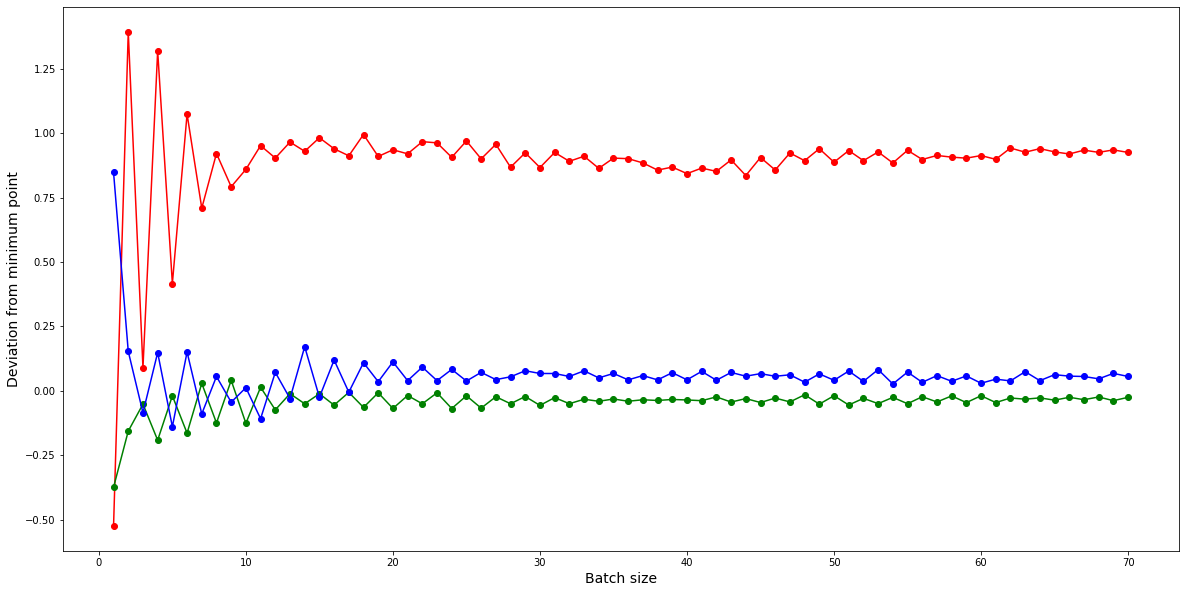

In [712]:
a = [25, 2, 15]
t, ft = generate_dataset(a, 10, 100, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [9, 0.5, 1]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

n = 70
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr)[-1])

min_points = np.array(min_points)
deviation = a - min_points
print(deviation)
print(min_points)

tt = np.linspace(1, n, n)
plt.gca().set_xlabel('Batch size', fontsize=14)
plt.gca().set_ylabel('Deviation from minimum point', fontsize=14)
plt.plot(tt, deviation[:, 0], '-o', color='red')
plt.plot(tt, deviation[:, 1], '-o', color='green')
plt.plot(tt, deviation[:, 2], '-o', color='blue')

## Решение задачи простой линейной регрессии с использованием standart scaler
Можно заметить, что после scaling функция изменяется более равномерно по всем измерениям. Значительное улучшение сходимости. Отсутствие необходимости подбирать lr по каждой переменной.

Precision: [0.73683582 0.36265478]
Min point: [9.26316418 4.63734522]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 1.9739464   4.26211935]
 [ 2.89764076  8.10167754]
 [ 3.42003814 10.06078513]
 [ 4.81868067 12.25896091]
 [ 5.53342331 13.85437834]
 [ 6.24916706 15.2771561 ]
 [ 7.21555451 17.54491474]
 [ 7.32888597 18.72467249]
 [ 7.45207476 20.14074136]
 [ 7.10210062 20.89355792]
 [ 7.08595092 21.78264109]
 [ 7.17865059 22.68259064]
 [ 7.13708138 23.51667767]
 [ 7.06982444 24.23078775]
 [ 6.98307849 24.60536942]
 [ 7.13169369 25.19927956]
 [ 7.19410262 25.50283854]
 [ 7.49973594 26.08170556]
 [ 7.77038081 26.55311491]]


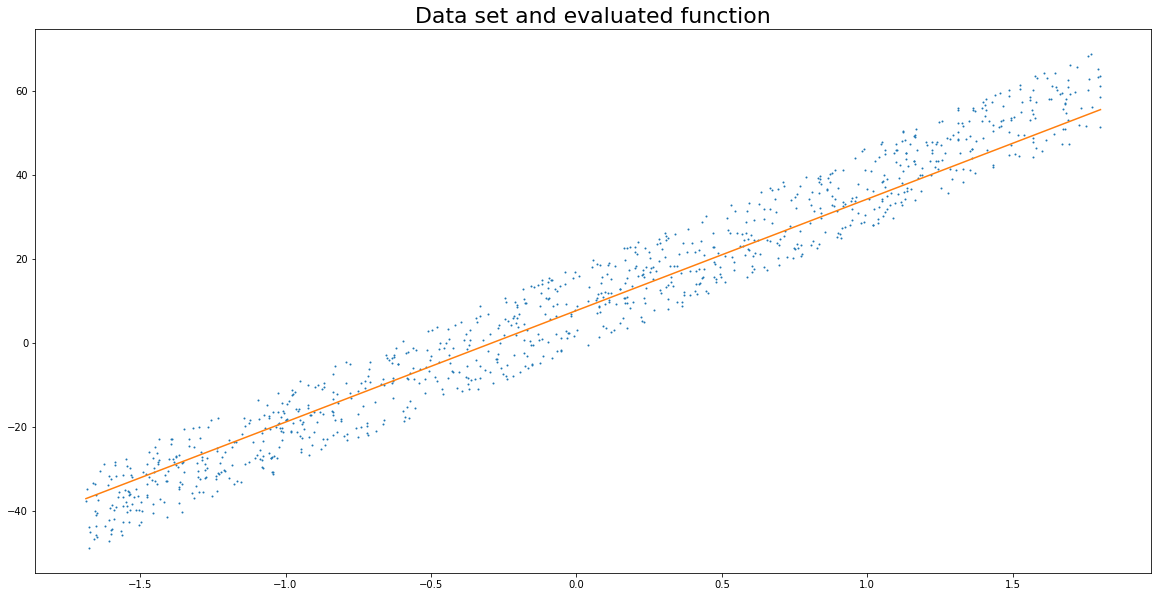

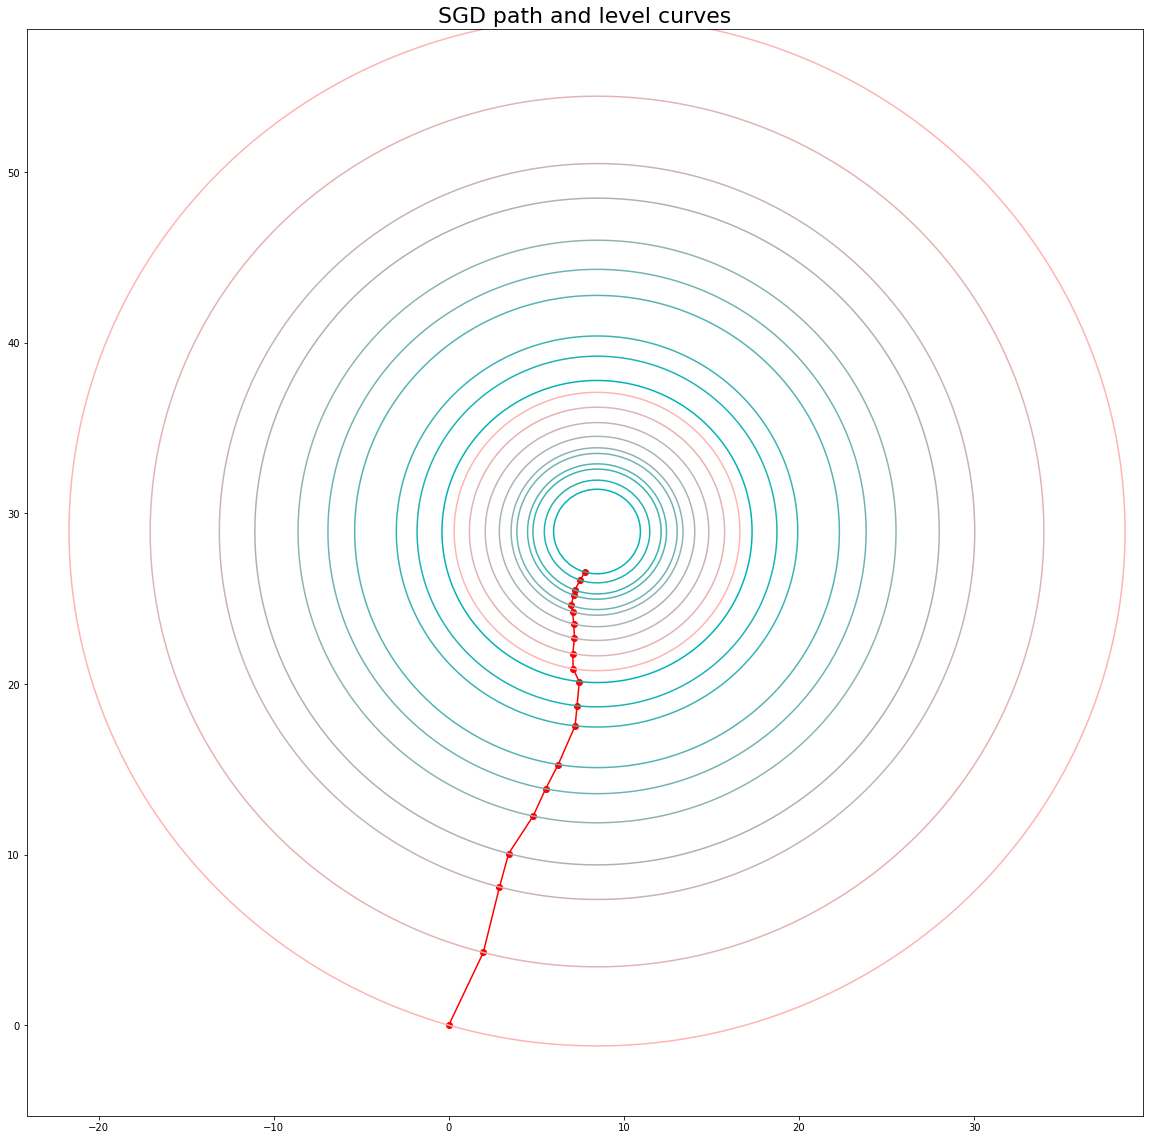

In [713]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
scaler = StandartScaler(t)
t = scaler.scale(t)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points, scaler.reverse_min_point(points[-1]))
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Сравнение до и после standart scaling

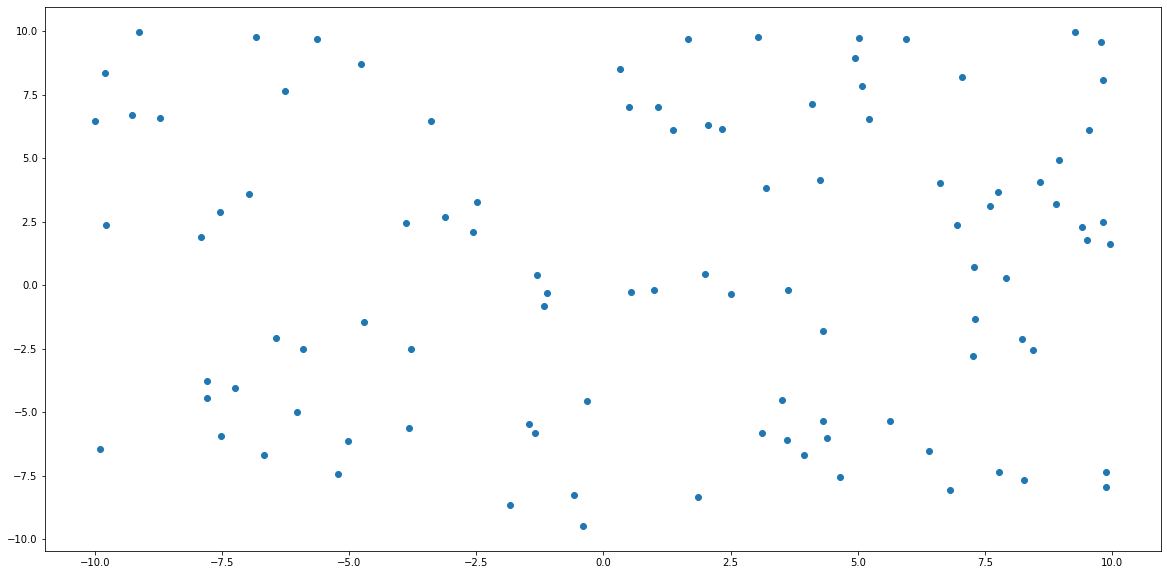

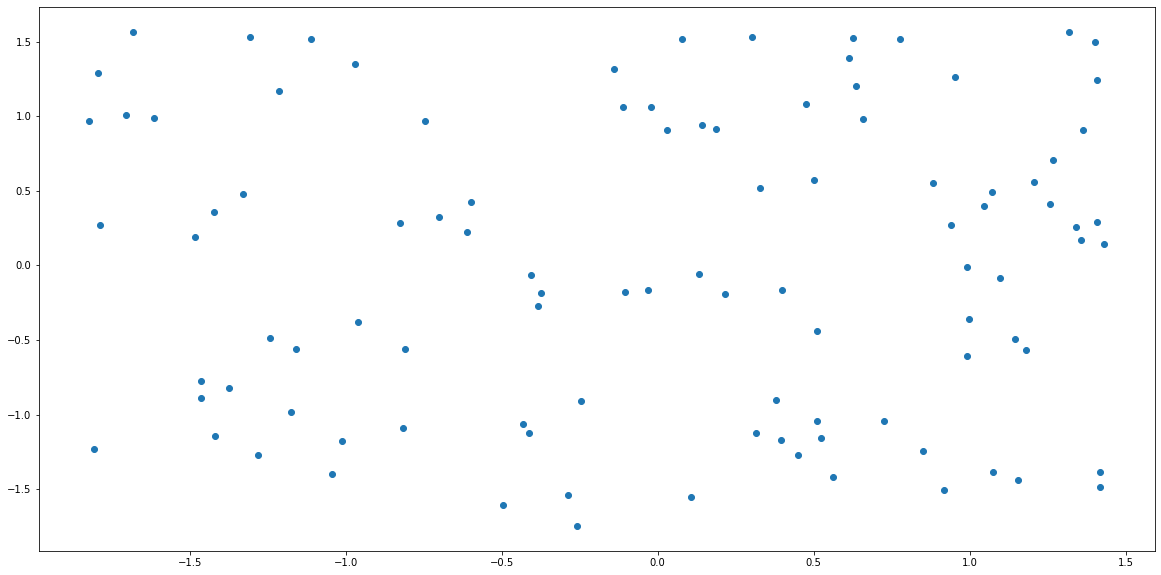

In [714]:
a = [10, -3, 5]
t = generate_dataset(a, 3, 100, (-10, 10))[0]

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

scaler = StandartScaler(t)
t = scaler.scale(t)

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

## SGD with momentum

Precision: [0.72889582 0.09317853]
Min point: [9.27110418 4.90682147]
Iterations: 20
Path: [[0.00000000e+00 0.00000000e+00]
 [1.64115491e-03 8.25707021e-01]
 [6.25166091e-01 2.13302569e+00]
 [1.68972998e+00 3.32601021e+00]
 [2.60267585e+00 4.09332864e+00]
 [3.28369908e+00 4.57149816e+00]
 [3.88347135e+00 4.89588272e+00]
 [4.46158508e+00 5.09262267e+00]
 [5.08180820e+00 5.20146466e+00]
 [5.68487753e+00 5.26787161e+00]
 [6.22851627e+00 5.18130579e+00]
 [6.76120633e+00 5.06334466e+00]
 [7.25414302e+00 5.01117309e+00]
 [7.74615782e+00 4.95369643e+00]
 [8.06873712e+00 4.96039124e+00]
 [8.23505935e+00 4.94419245e+00]
 [8.37587734e+00 4.91772740e+00]
 [8.70303417e+00 4.87946077e+00]
 [9.07473561e+00 4.88304324e+00]
 [9.27110418e+00 4.90682147e+00]]


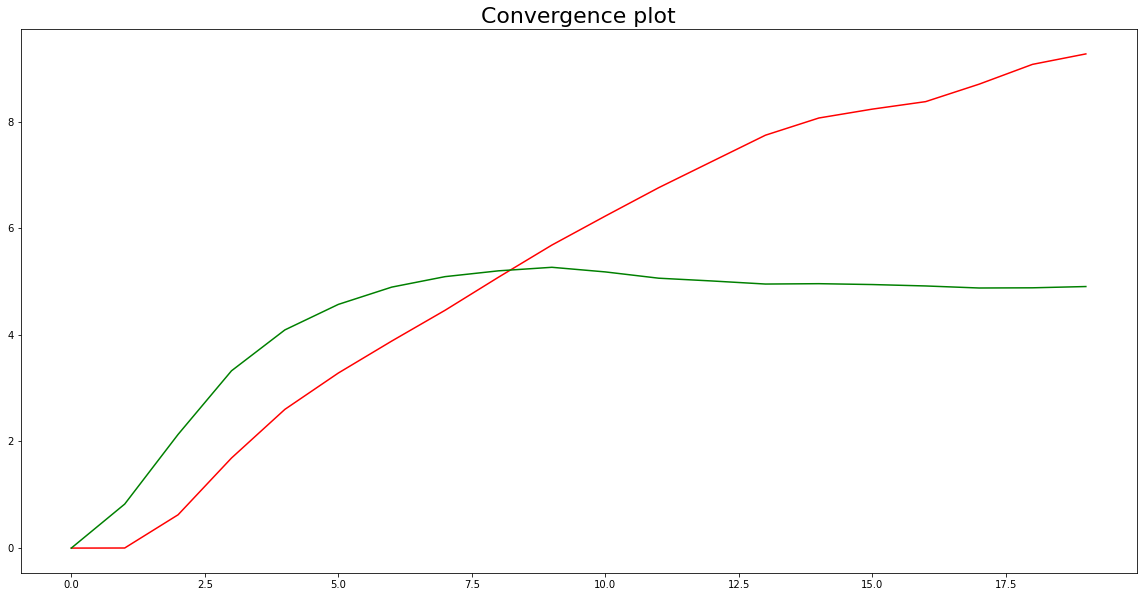

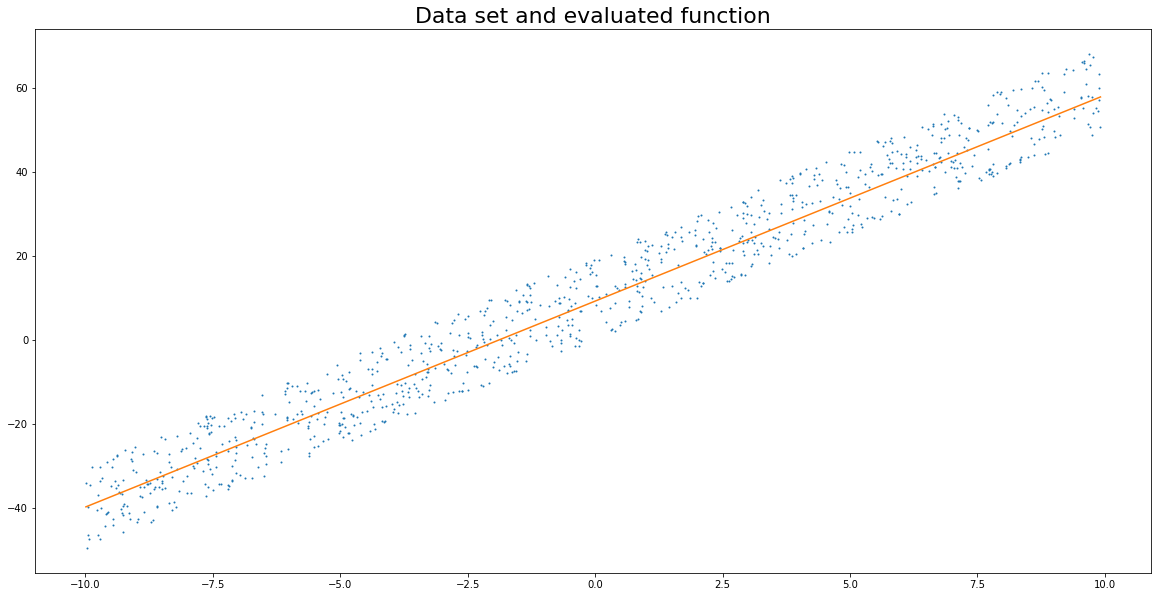

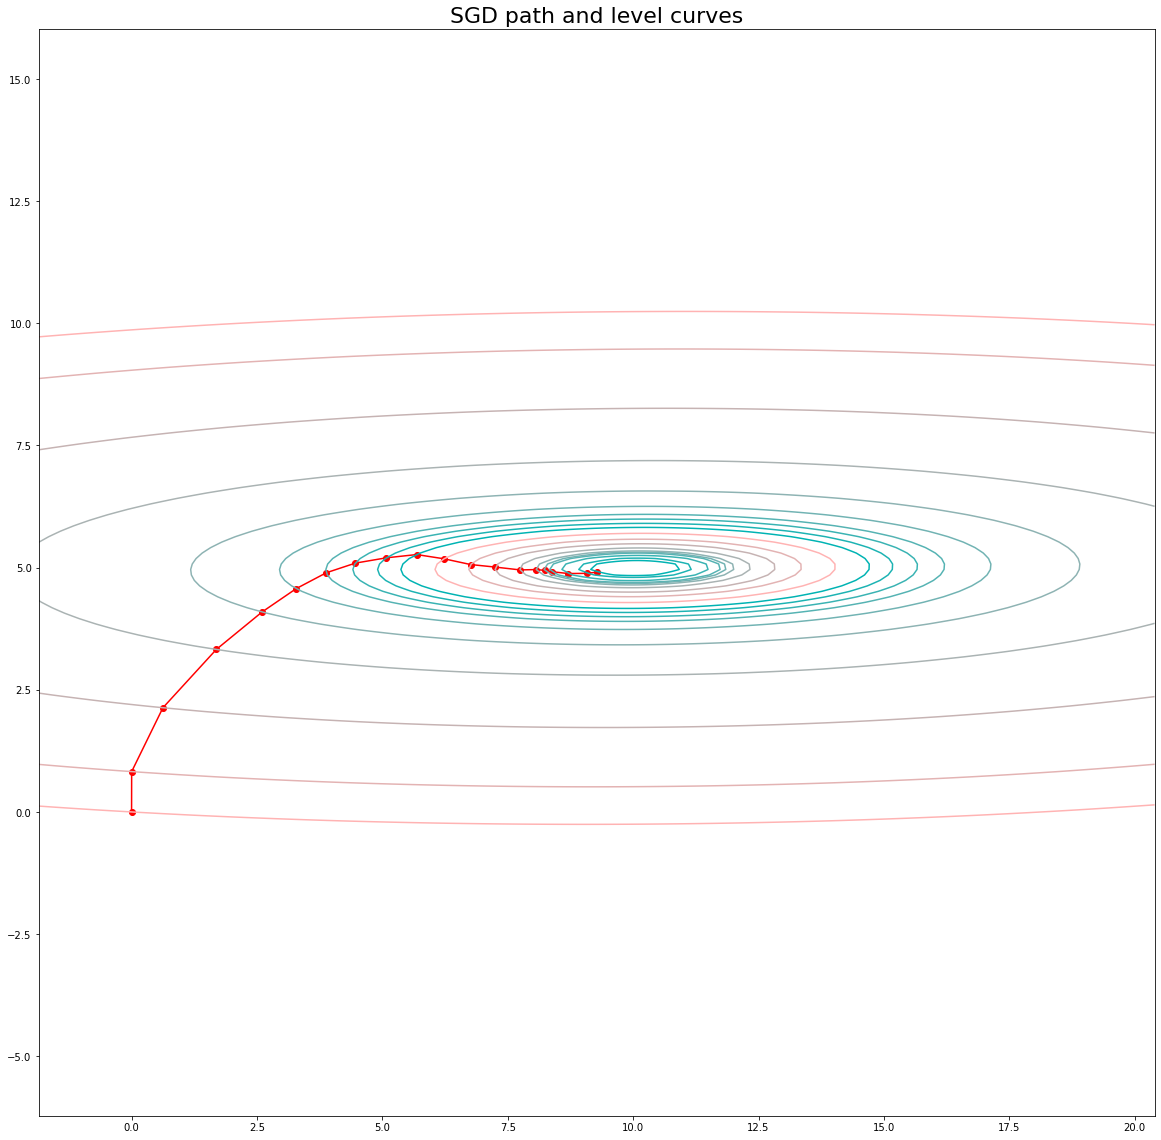

In [715]:
"""
Находит минимум функции, используя стохастический градиентный спуск с импульсом.

Отличие от обычного SGD в том, что добавился параметр b. 
Теперь при вычислении градиента в новой точке можно учитывать градиент во всех предыдущих.
Чем дальше номер точки от текущего номера, тем меньший вклад градиент в ней вносит в текущий градиент.
Такой подход призван предотвратить излишние колебания минимизируемой функции вблизи её минимума.

@param b: вес градиента в предыдущих точках
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]],
                 x:ndarray, max_epoch:int, batch_size:int,
                 lr:List[float], b:List[float] = (0),
                 scheduler:Callable[[List[float]], float] = lambda lr: lr,
                 stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    g = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points.append(x)
    return np.array(points)

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 5]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Nesterov SGD

Precision: [8.69068046 3.5704453 ]
Min point: [1.30931954 1.4295547 ]
Iterations: 20
Path: [[0.         0.        ]
 [0.01531249 0.17008356]
 [0.03743359 0.1794051 ]
 [0.0696716  0.32761118]
 [0.12000897 0.33956744]
 [0.17720267 0.44353241]
 [0.23980239 0.5026053 ]
 [0.31131803 0.60552397]
 [0.38750599 0.6727617 ]
 [0.46512556 0.75688863]
 [0.54611278 0.81096593]
 [0.62804712 0.90966588]
 [0.71342375 0.95256527]
 [0.79642135 1.0292378 ]
 [0.88039741 1.1005051 ]
 [0.96492877 1.17313898]
 [1.05117256 1.23645424]
 [1.13702658 1.30390724]
 [1.22437385 1.37540463]
 [1.30931954 1.4295547 ]]


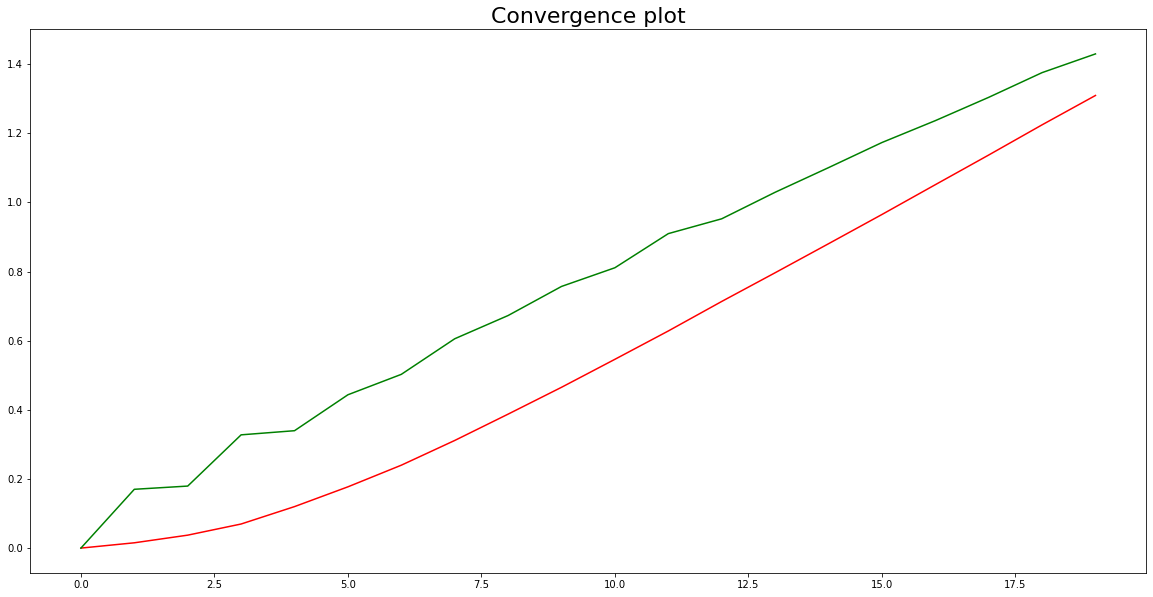

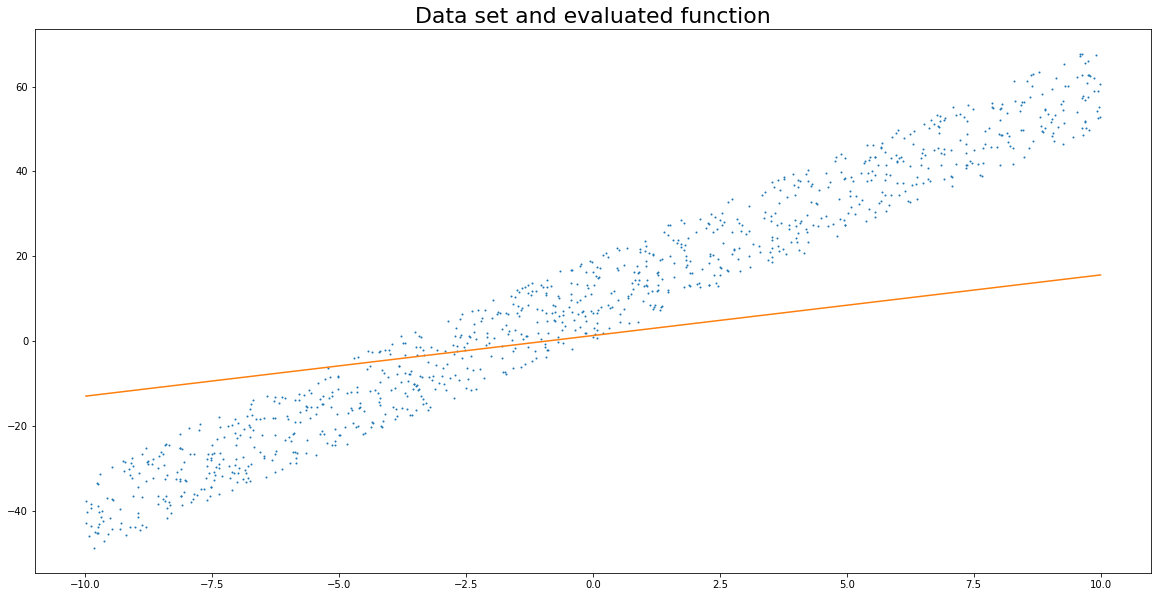

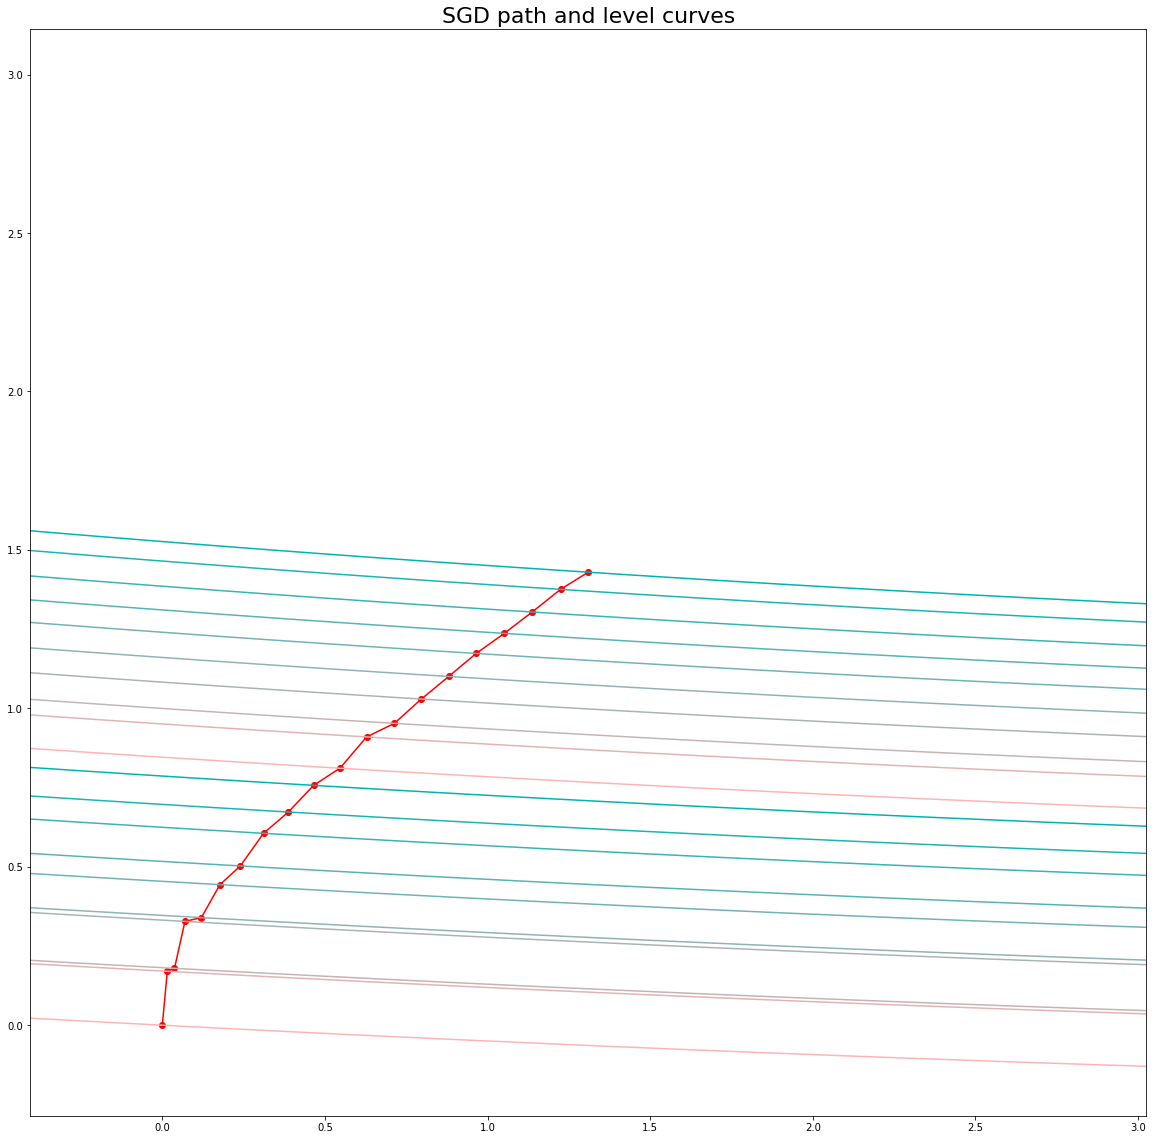

In [716]:
"""
Находит минимум функции, используя стохастический градиентный спуск с использованием алгоритма Нестерова.

Аналогична SGD c импульсом, но в добавок вычисляет градиент на каждом шаге, не в точке x, а в точке x - b * g,
где g - направление спуска на прошлом шаге.

По неизвестным причинам такой спуск работает намного хуже остальных.
Он либо сходится крайне медленно, либо чрезвычайно быстро расходится.
При этом грань между сходимость и расходимостью очень тонкая.

@param b: вес градиента в предыдущих точках
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int,
                 lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr,
                 stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    g = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points.append(x)
    return np.array(points)

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [2, 1]
b = [0.9]

points = sgd_nesterov(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with AdaGrad

Precision: [-0.2257624   0.07349888]
Min point: [20.2257624   4.92650112]
Iterations: 20
Path: [[ 0.          0.        ]
 [19.99999982 19.99999998]
 [28.8919064   1.57158521]
 [25.68478579  6.35129514]
 [21.53649583  4.2805339 ]
 [21.77870214  5.16085784]
 [21.34347845  4.89916517]
 [21.14292538  5.15790025]
 [20.53923137  5.00691947]
 [20.85290809  5.03270676]
 [19.88973876  4.93912859]
 [20.10358284  4.90416   ]
 [20.04962863  4.74142943]
 [19.27077418  4.99557248]
 [19.57124148  4.83413306]
 [19.62854998  5.44154198]
 [21.48570198  5.03730515]
 [20.33758624  4.91456804]
 [19.93199298  5.22157767]
 [20.2257624   4.92650112]]


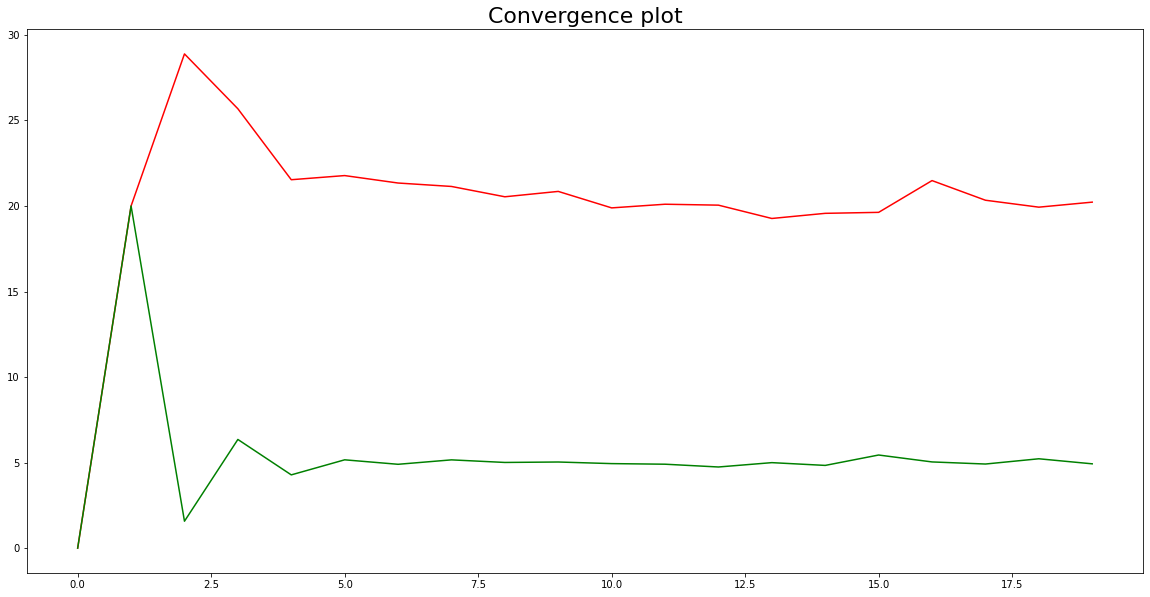

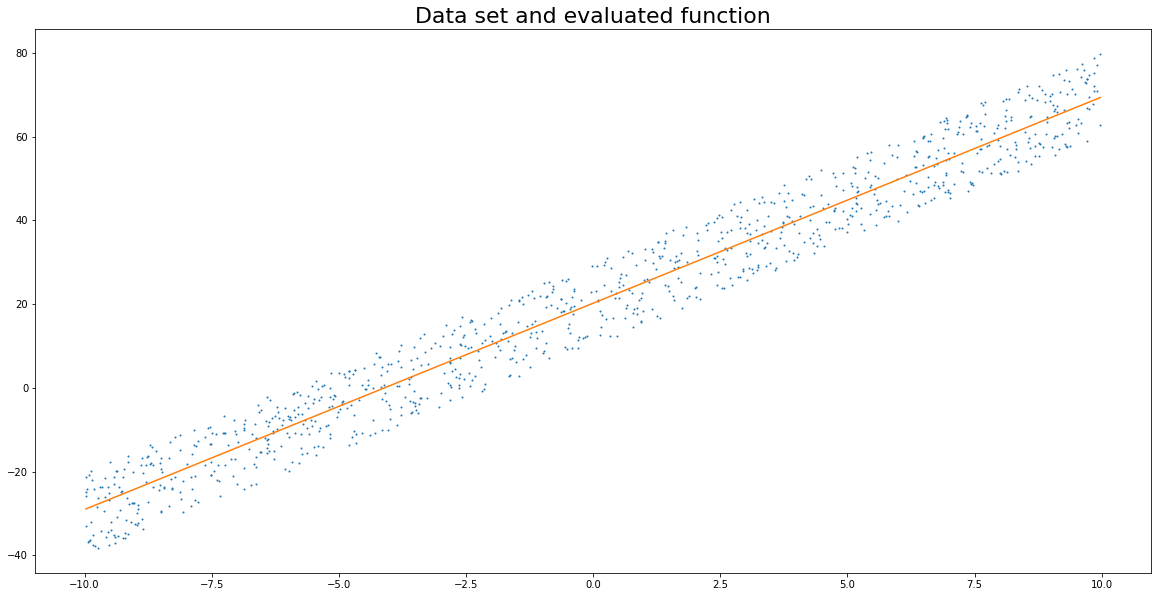

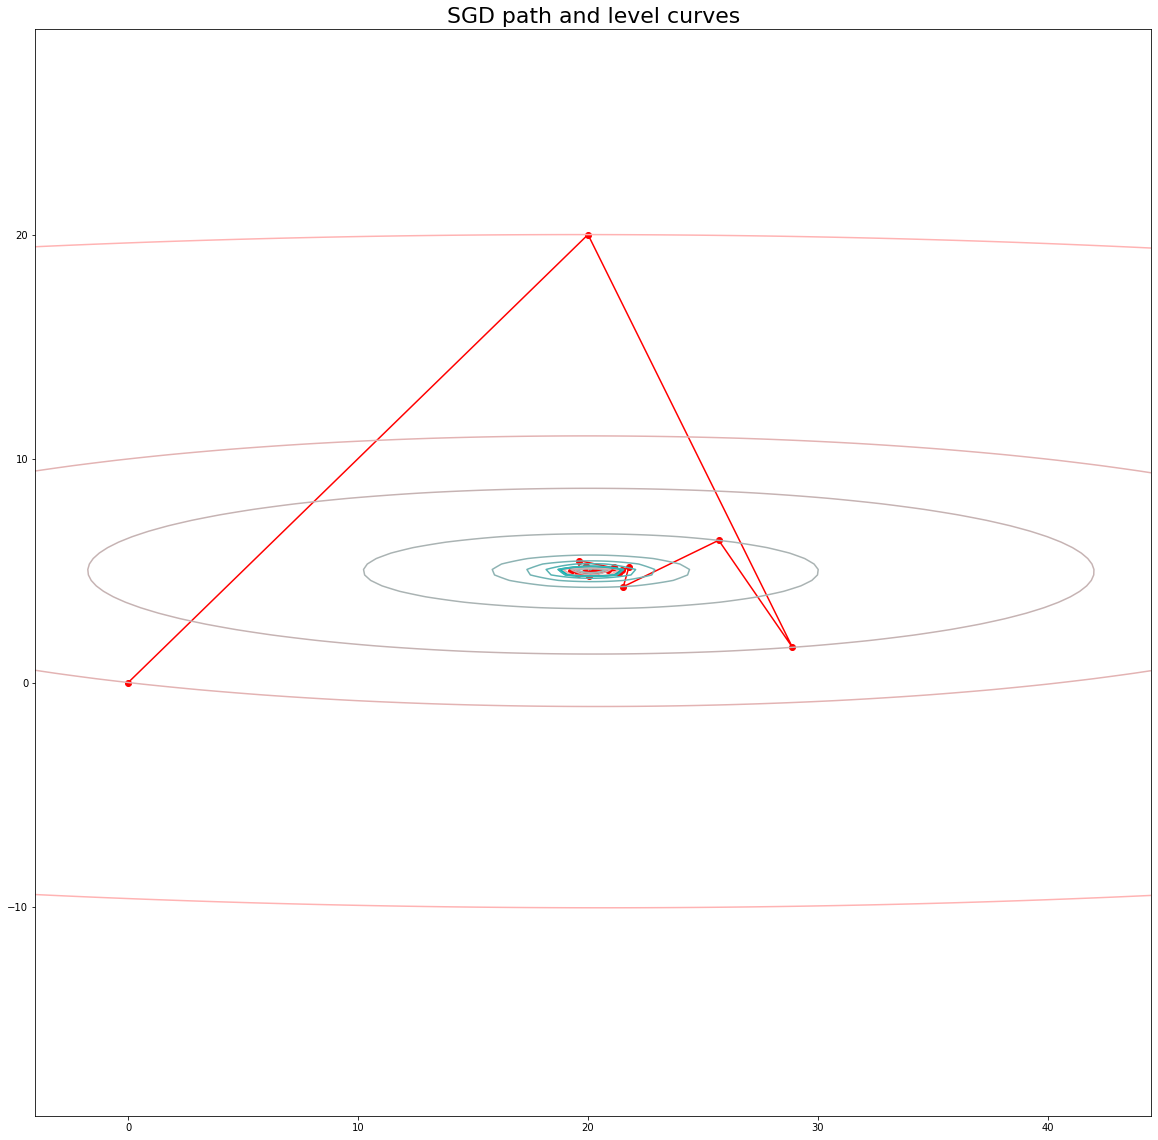

In [717]:
"""
Находит минимум функции, используя стохастический градиентный спуск с AdaGrad (адаптивный градиент).

Теперь величина шага накапливается в переменной v. С помощью накопленной величины редактируется размер шага в направлении антиградиента на текущей итерации. Само направление при этом выбирается стандартным образом.

Уменьшает колебания. Даёт возможность использовать одинаковый lr по всем направлениям даже без использования scaler.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    v = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points.append(x)
    return np.array(points)

a = [20, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 1000

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with RMSProp

Precision: [0.06311931 0.05934928]
Min point: [14.93688069  4.94065072]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 3.79473307  3.79473318]
 [ 5.60120587  4.53501478]
 [ 7.39092172  5.07182902]
 [ 8.66889791  4.95136235]
 [ 9.7358699   4.89366382]
 [10.45910831  4.99850262]
 [11.25149221  5.0857861 ]
 [11.86197141  4.8054138 ]
 [12.31458647  4.92922768]
 [12.72030281  4.75918297]
 [13.01453785  4.9623685 ]
 [13.60305848  5.03948282]
 [13.88439414  5.38547463]
 [13.88965659  4.71264372]
 [14.39214449  5.22372318]
 [14.54324327  4.64320423]
 [14.81146432  5.0482203 ]
 [14.58076978  4.98856651]
 [14.93688069  4.94065072]]


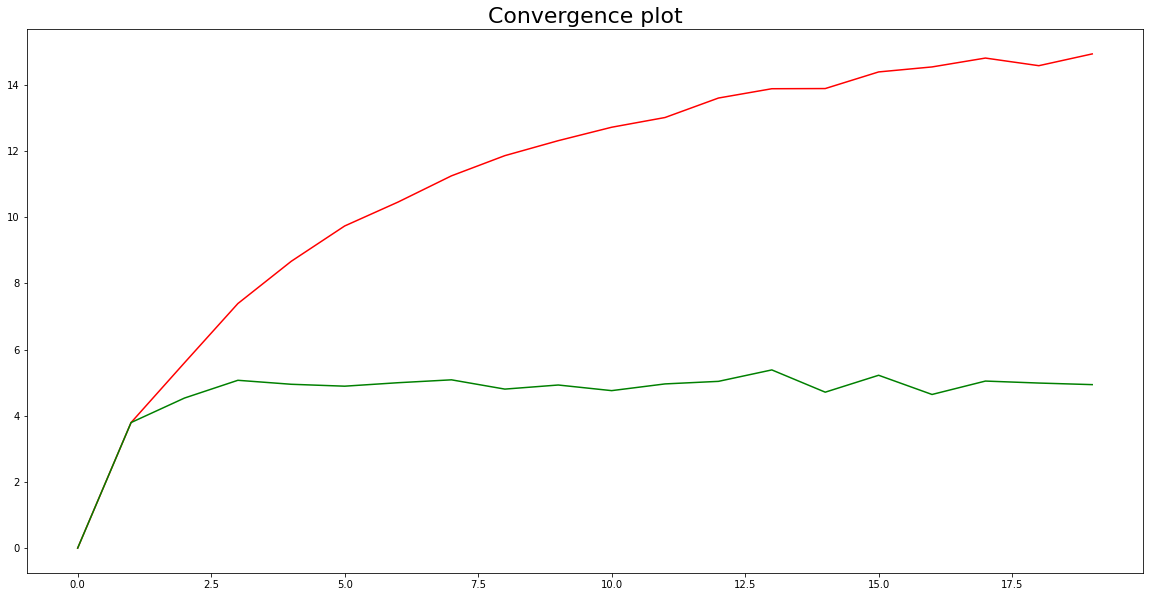

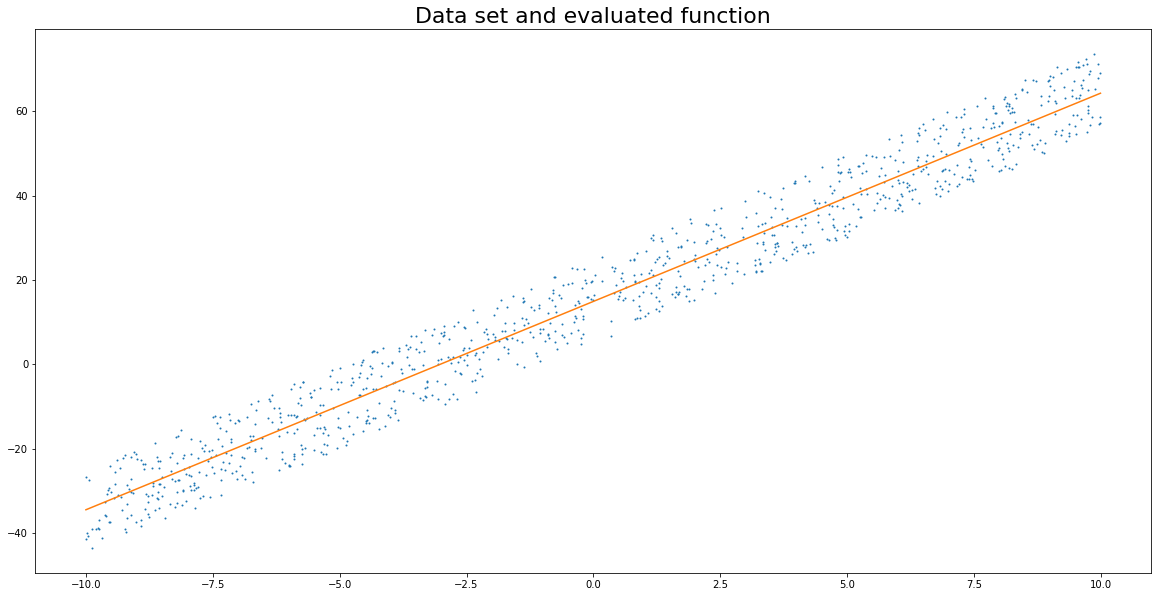

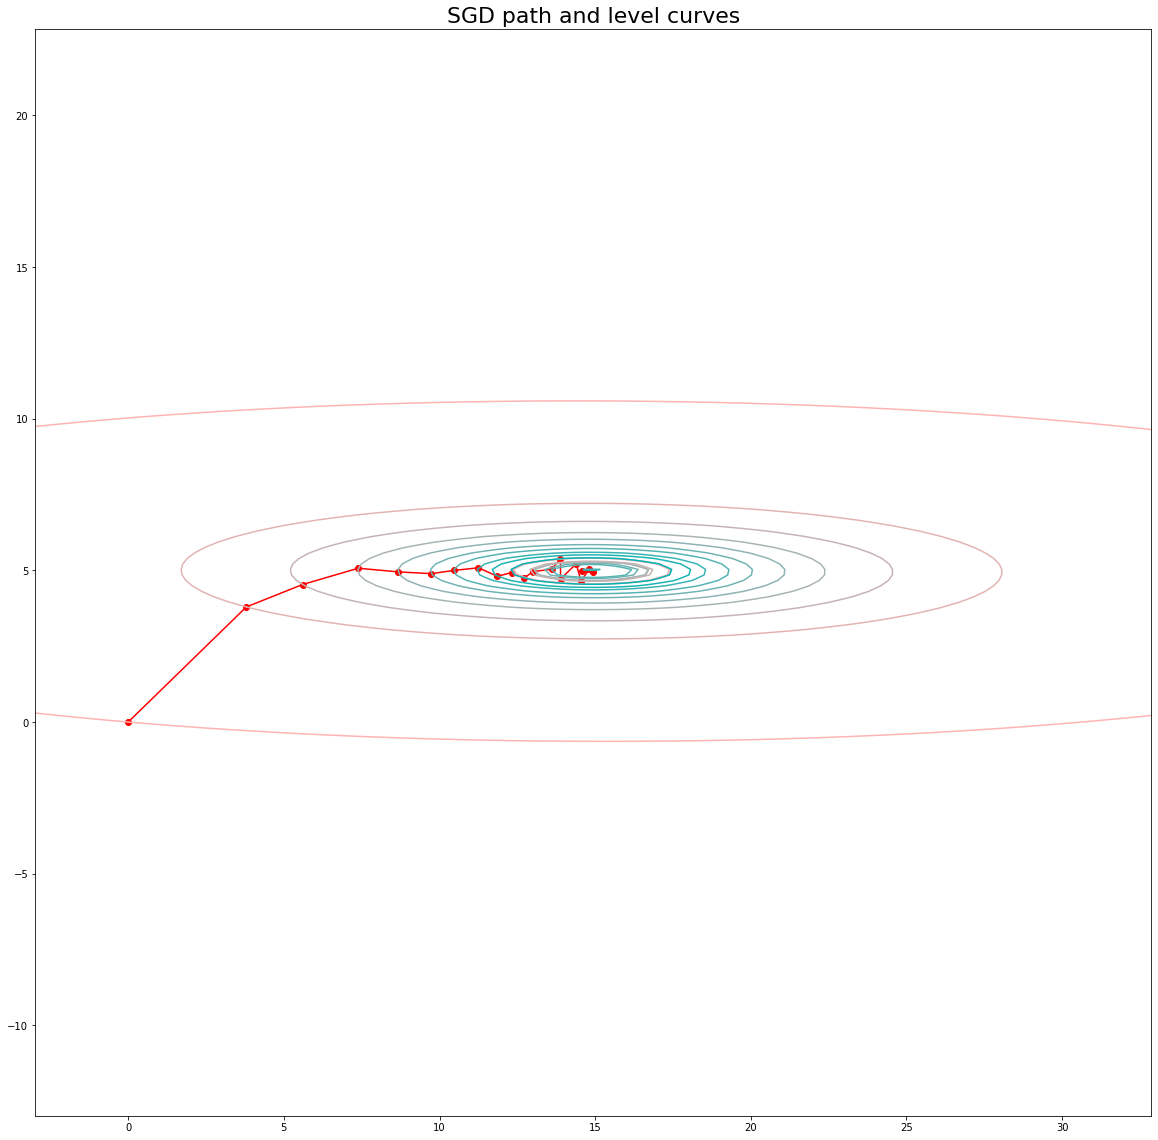

In [718]:
"""
Находит минимум функции, используя стохастический градиентный спуск с помощью rmsprop.

Алгоритм действует аналогично AdaGrad, но теперь шаг накапливается с инерцией, изменяясь, как скользящее среднее шагов на прошлых итерациях.

@param b: вес шагов (евклидова норма градиента) в предыдущих точках

"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = [x]
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points.append(x)
    return np.array(points)


a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 60
b = 0.9

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with Adam

Precision: [0.06319344 0.17198972]
Min point: [14.93680656  4.82801028]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 2.85368813  2.85368826]
 [ 5.78703663  5.28680254]
 [ 8.13546271  6.78831913]
 [10.1464411   7.01131046]
 [11.67501594  6.63983292]
 [13.00904512  6.04975581]
 [13.89720418  5.37921779]
 [14.33592678  4.98420372]
 [14.8452676   4.650863  ]
 [15.22852993  4.69494988]
 [15.57197491  4.84576279]
 [15.90441201  5.15334355]
 [15.78492563  5.5740062 ]
 [15.50239341  5.27789988]
 [14.9241973   4.77372837]
 [14.1086353   4.46844038]
 [14.8498815   5.11053543]
 [14.9953003   5.29439874]
 [14.93680656  4.82801028]]


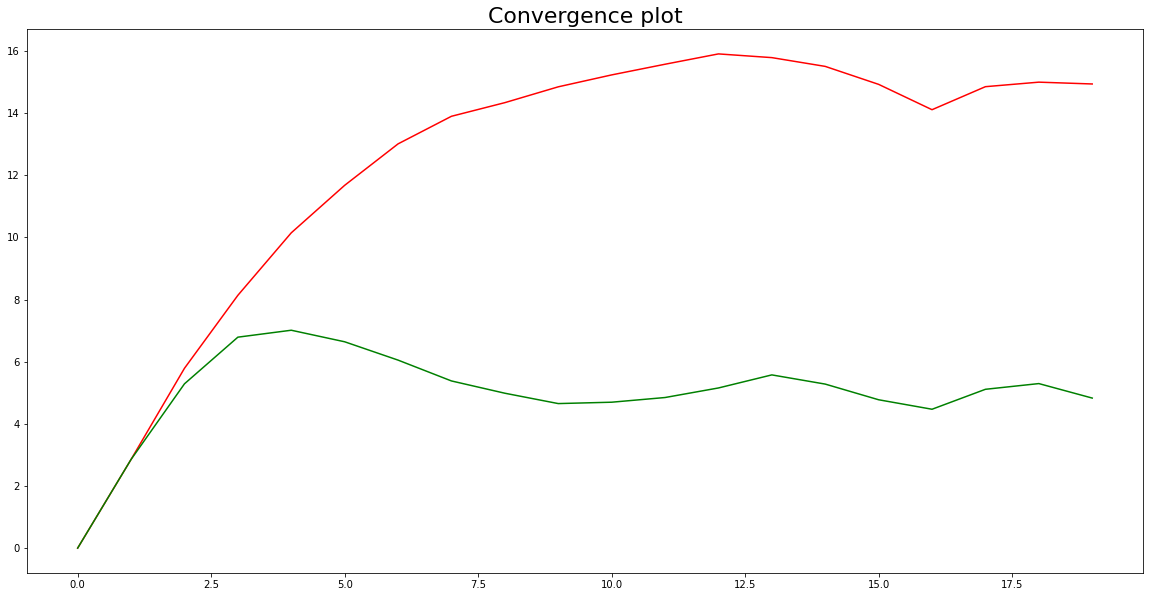

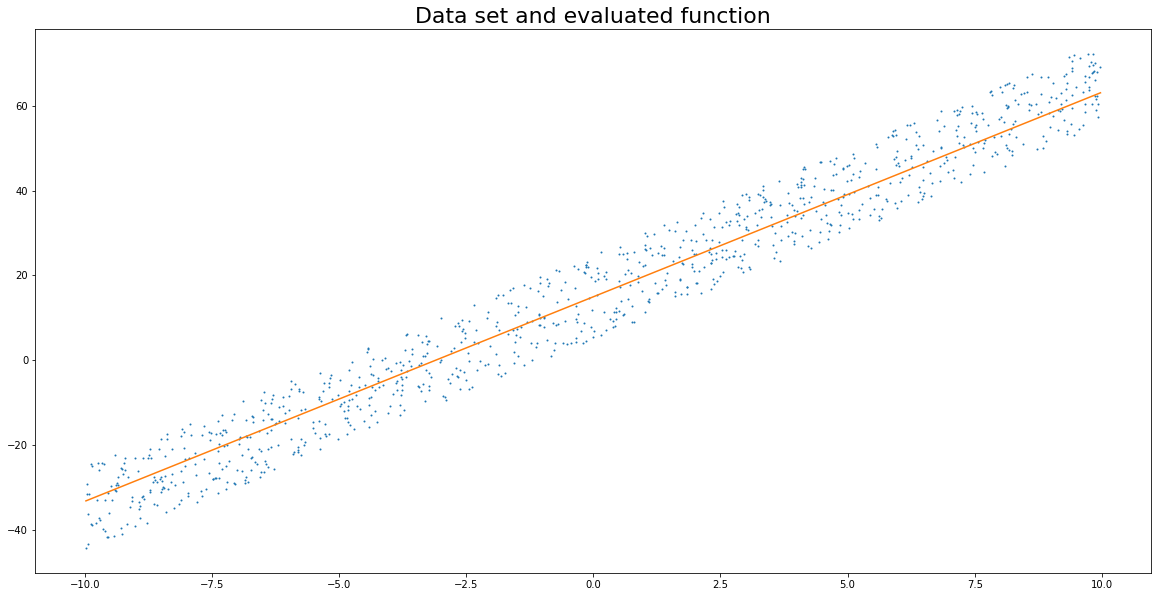

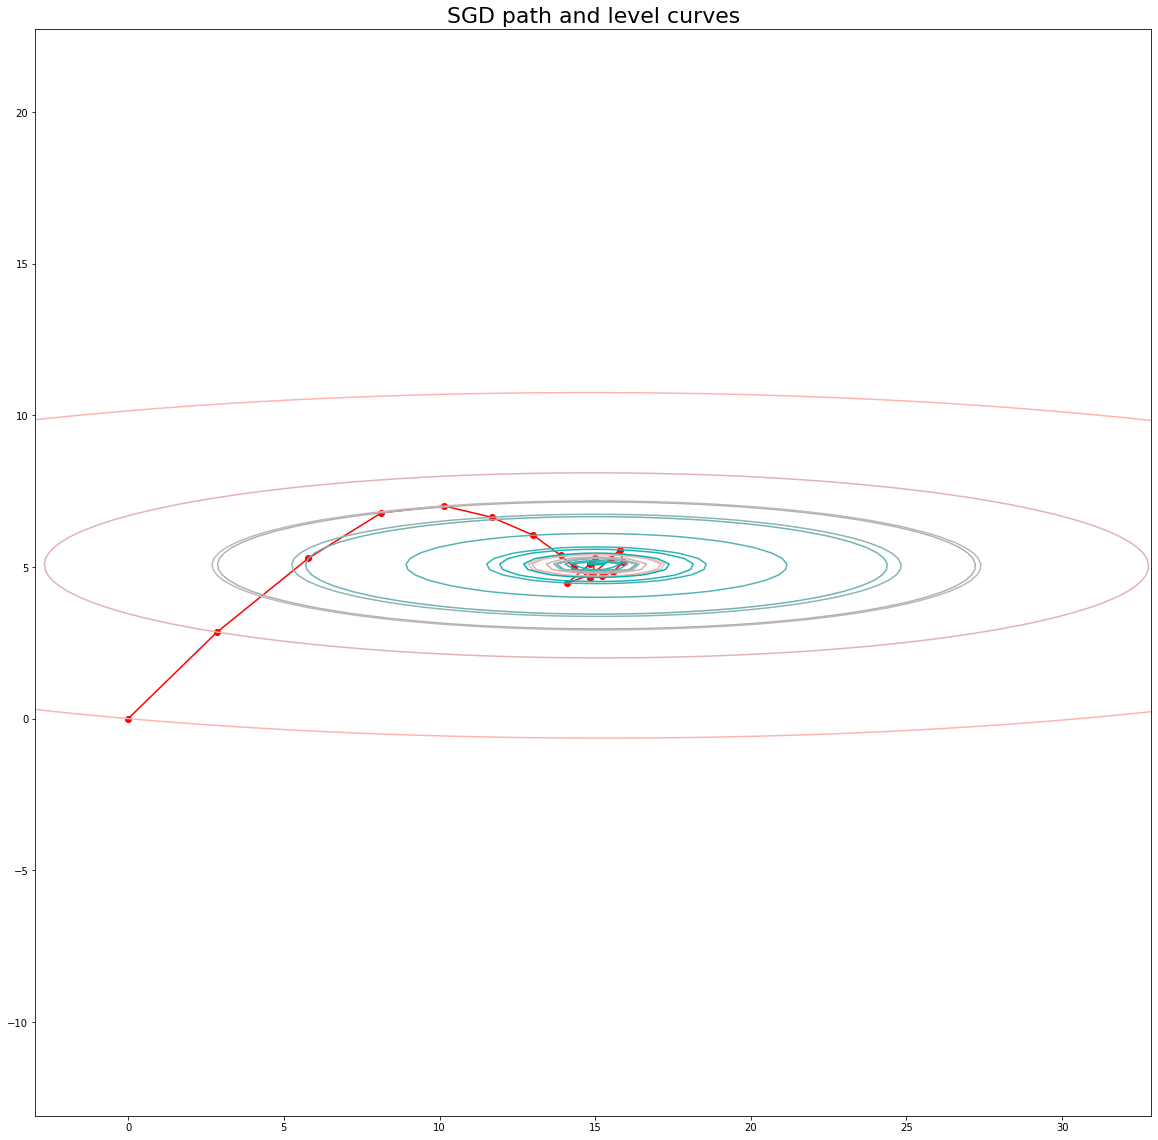

In [719]:
"""
Находит минимум функции, используя стохастический градиентный спуск с помощью adam.

Adam вобрал в себя идеи RMSProp и SGD with momentum. Теперь и величина шага, и направление шага корректируются, 
как скользящее среднее величины шага и его направления на прошлых итерациях.
Подобный подход позволяет значительно уменьшить колебания спуска вблизи минимума.
Более того, этот алгоритм, как и RMSProp, 
будет хорошо сходиться даже в условиях отсутствия предварительной нормировки данных,
с одинаковым lr по всем направлениям (features).
Возможно, этот алгоритм на даёт лучшей сходимости всегда, 
но он определённо надеждней многих прочих в большинстве случаев.

@param b1:вес градиента в предыдущих точках
@param b2: вес шагов (евклидова норма градиента) в предыдущих точках
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = [x]
    m = 0
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points.append(x)
    return np.array(points)

a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Траектория спуска обычного SGD для одномерного пространства регрессоров
На графике также отображены линии равного уровня минимизируемой функции

Precision: [ 0.44865146 -0.01766662]
Min point: [ 9.55134854 -2.98233338]
Iterations: 40
Path: [[ 0.          0.        ]
 [ 1.06625767 -0.32980566]
 [ 1.33376688 -0.52838664]
 [ 1.76095249 -0.65296757]
 [ 1.82319685 -0.78630215]
 [ 2.31863501 -1.01961792]
 [ 2.76521525 -1.14751583]
 [ 3.15318469 -1.30920377]
 [ 3.98573344 -1.52320252]
 [ 4.48088064 -1.6760709 ]
 [ 5.13798647 -1.84067161]
 [ 5.37770508 -1.96828715]
 [ 5.74798278 -2.08369712]
 [ 5.9886394  -2.21775305]
 [ 6.2784011  -2.29677029]
 [ 6.44245927 -2.34285009]
 [ 6.82697605 -2.41595664]
 [ 7.12920487 -2.46399798]
 [ 7.3059889  -2.54139421]
 [ 7.30549183 -2.54251548]
 [ 7.5204495  -2.57573281]
 [ 7.84850725 -2.64989188]
 [ 8.16435647 -2.69807449]
 [ 8.32225243 -2.7188128 ]
 [ 8.39659028 -2.78187098]
 [ 8.57248057 -2.75909675]
 [ 8.74973623 -2.80927152]
 [ 8.86420458 -2.78740303]
 [ 8.85126501 -2.84813306]
 [ 8.81701738 -2.85716831]
 [ 9.09699109 -2.92519715]
 [ 9.27559739 -2.95562341]
 [ 9.2540395  -2.95408126]
 [ 9.24936926 

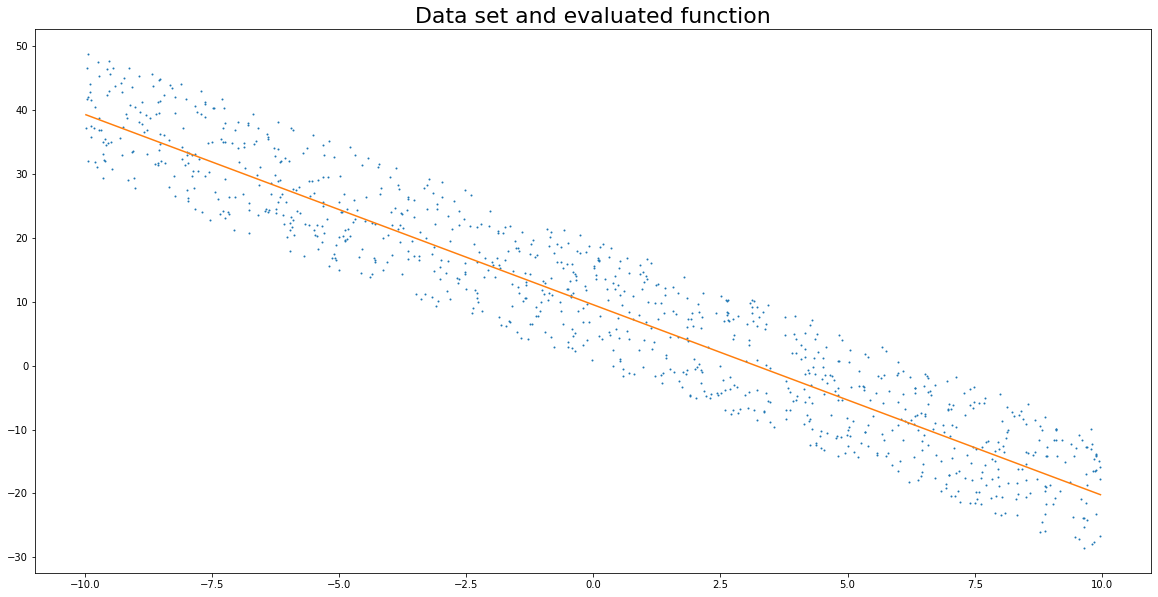

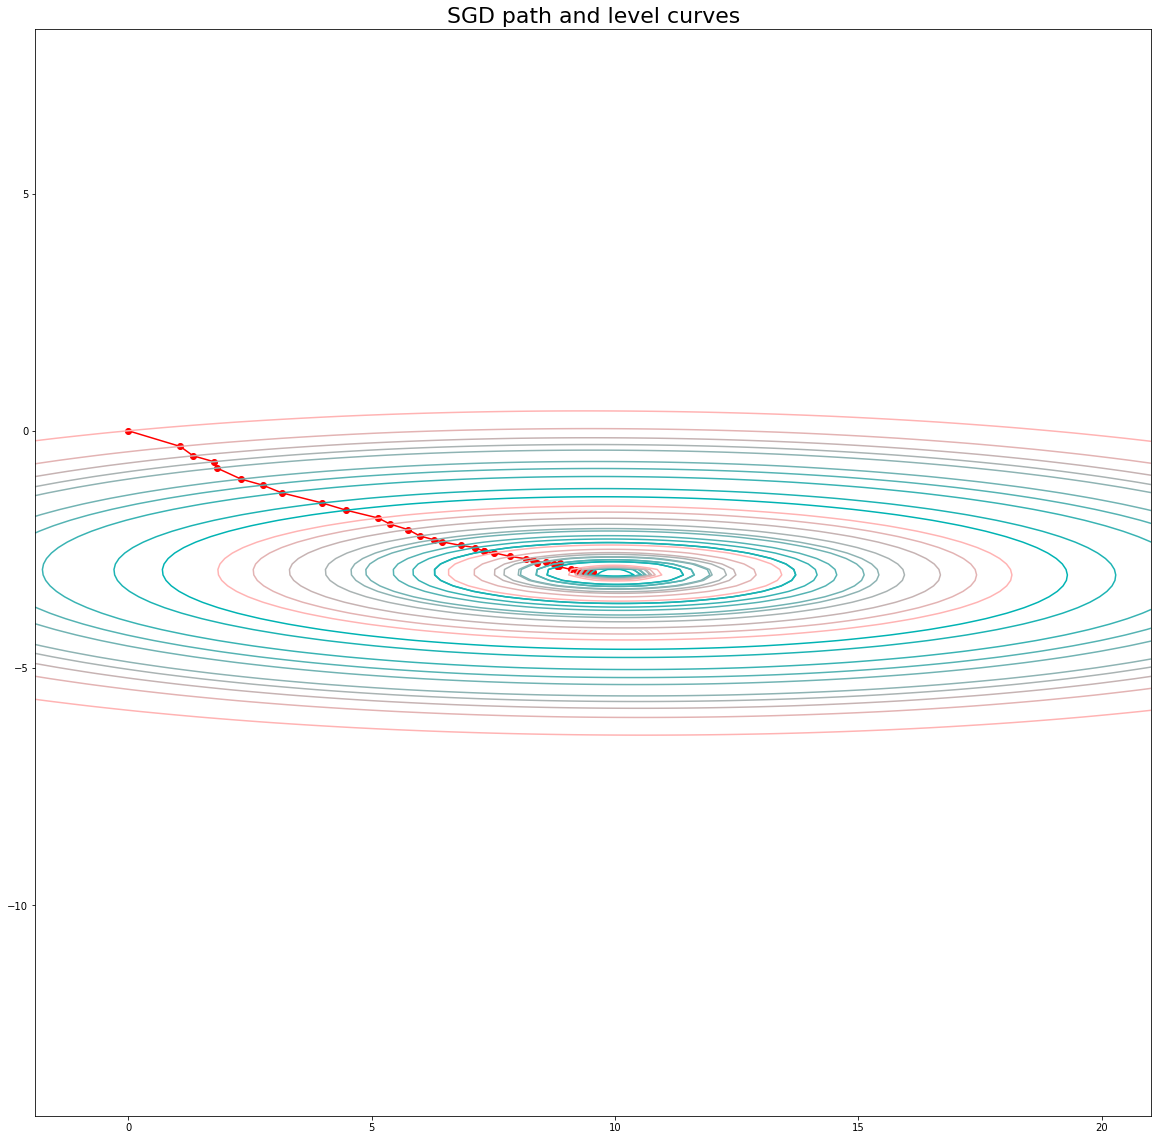

In [720]:
a = [10, -3]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = [70, 3]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Нагрузочное тестирование SGD_Nesterov

Process time: 0.0042529740232102415
Precision: [0.02879652 0.01841185]
Min point: [9.97120348 4.98158815]
Iterations: 376
Path: [[0.         0.        ]
 [0.03528234 0.20425652]
 [0.07057439 0.18693056]
 [0.11382328 0.36589133]
 [0.17731071 0.3592504 ]
 [0.24891368 0.51035715]
 [0.32471532 0.52277197]
 [0.40347436 0.68178803]
 [0.48873761 0.70460179]
 [0.5774997  0.82700394]
 [0.67203172 0.8695449 ]
 [0.76257287 0.95667663]
 [0.85375328 1.01861266]
 [0.94594097 1.09788471]
 [1.03718773 1.15541438]
 [1.12997163 1.23597353]
 [1.21934163 1.28835596]
 [1.30901325 1.37681247]
 [1.39240199 1.41144636]
 [1.47964965 1.48765131]
 [1.57025905 1.53032025]
 [1.66037762 1.61172666]
 [1.74571348 1.6475736 ]
 [1.83037719 1.72867386]
 [1.91399329 1.77237043]
 [1.9961988  1.83684248]
 [2.07829529 1.88104104]
 [2.16180012 1.93664851]
 [2.24242336 1.9853116 ]
 [2.32199979 2.04125942]
 [2.40226557 2.09152146]
 [2.48162939 2.14152034]
 [2.55934065 2.18980714]
 [2.63594936 2.24919783]
 [2.70769428 2.2943193

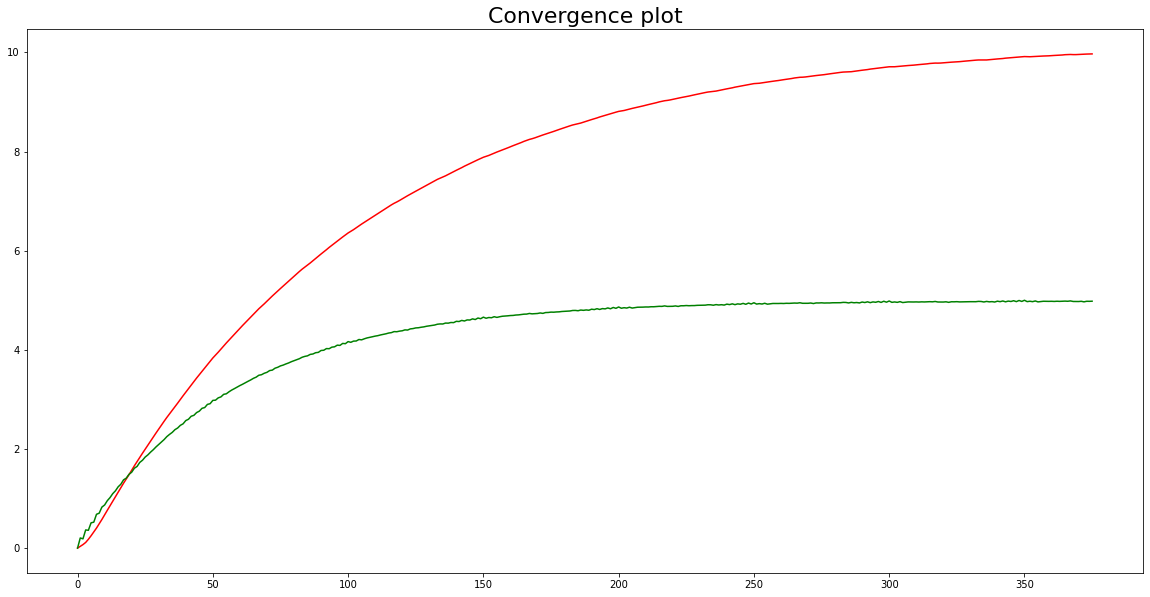

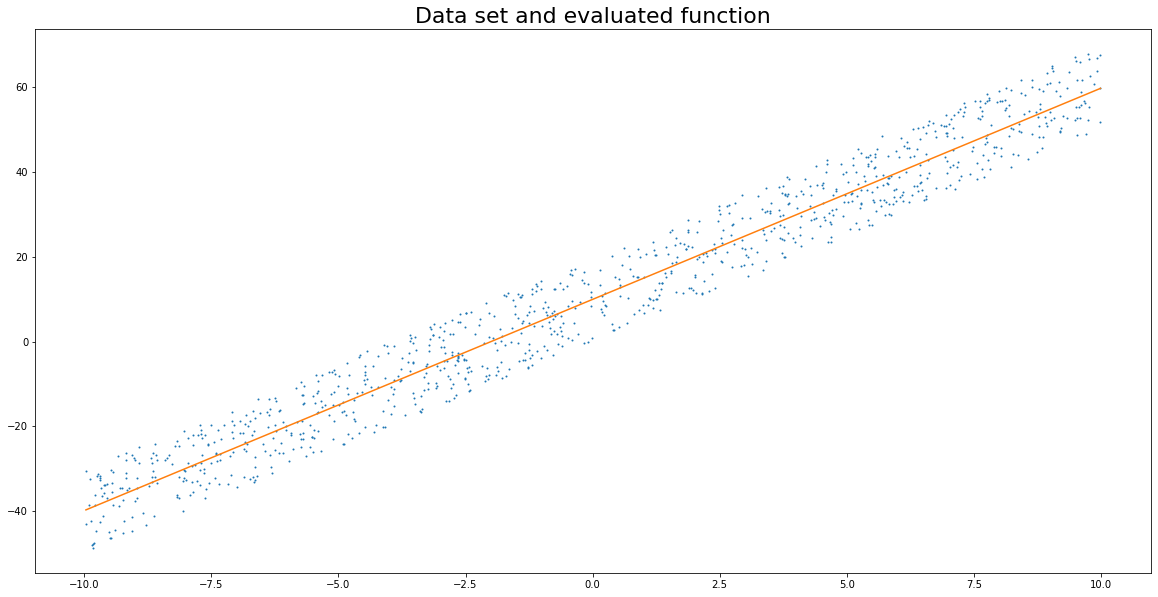

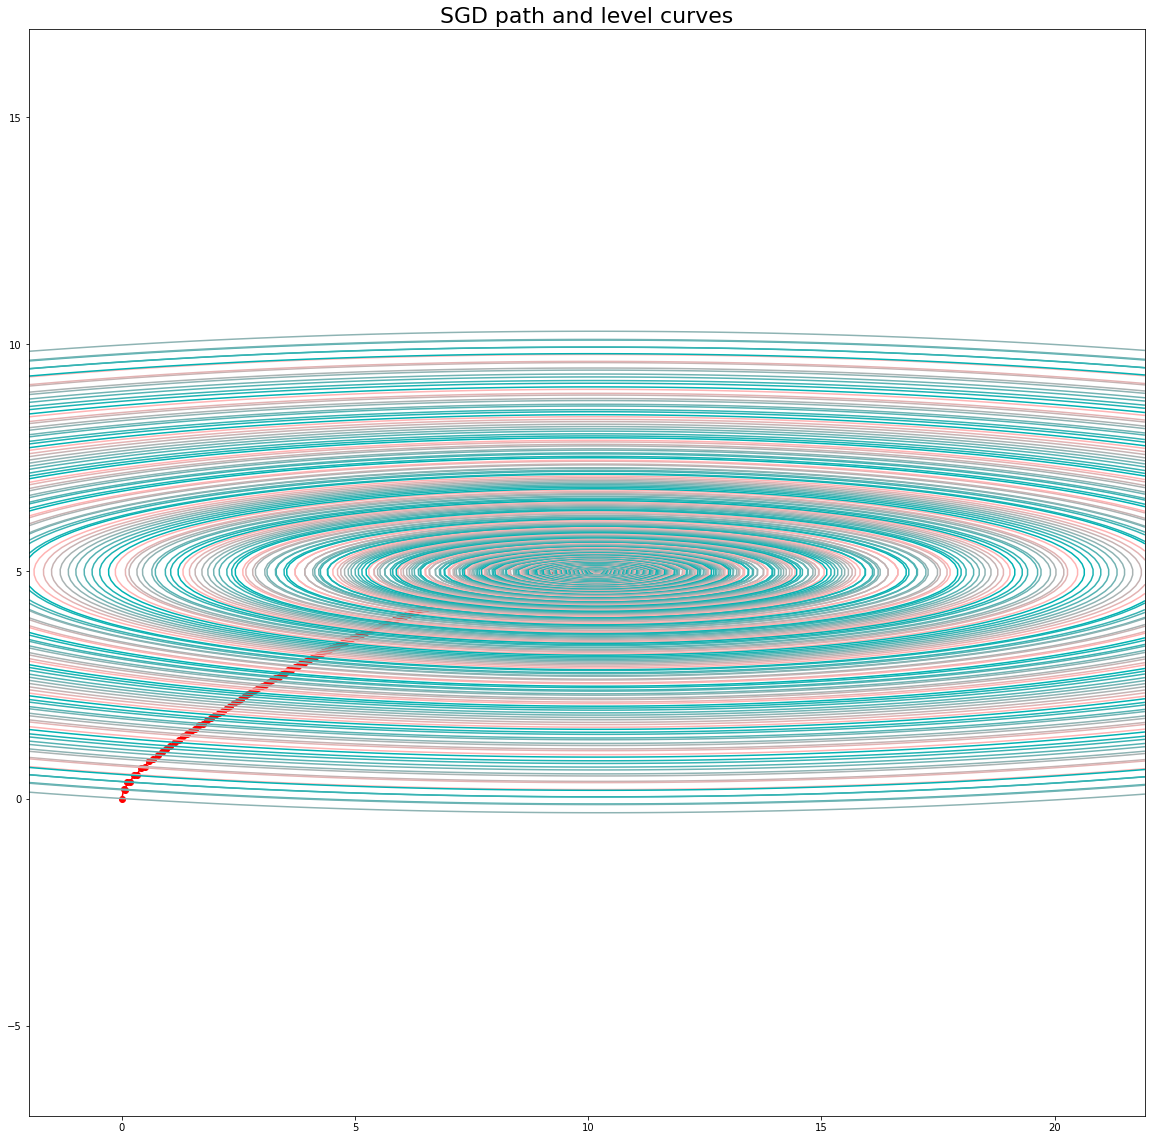

In [721]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
infinity_epoch = 1000
batch_size = 60
lr = [2, 1]
b = [0.9]
stop_criteria:Callable[[List[float]], bool]=lambda x: np.sum(np.abs(x - a)) < 0.05

start_time = time.time()
points = sgd_nesterov(sum_fun, x, infinity_epoch, batch_size, lr, b, stop_criteria=stop_criteria)
print(f'Process time: {(time.time() - start_time) / len(points)}')

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Нагрузочное тестирование SGD_Momentum

Process time: 0.004205939769744873
Precision: [-0.41515528 -0.01061543]
Min point: [10.41515528  5.01061543]
Iterations: 1000
Path: [[ 0.          0.        ]
 [ 0.47789999  0.92365833]
 [ 1.13910246  2.10389513]
 ...
 [10.34660472  5.01560359]
 [10.37856238  5.00216782]
 [10.41515528  5.01061543]]


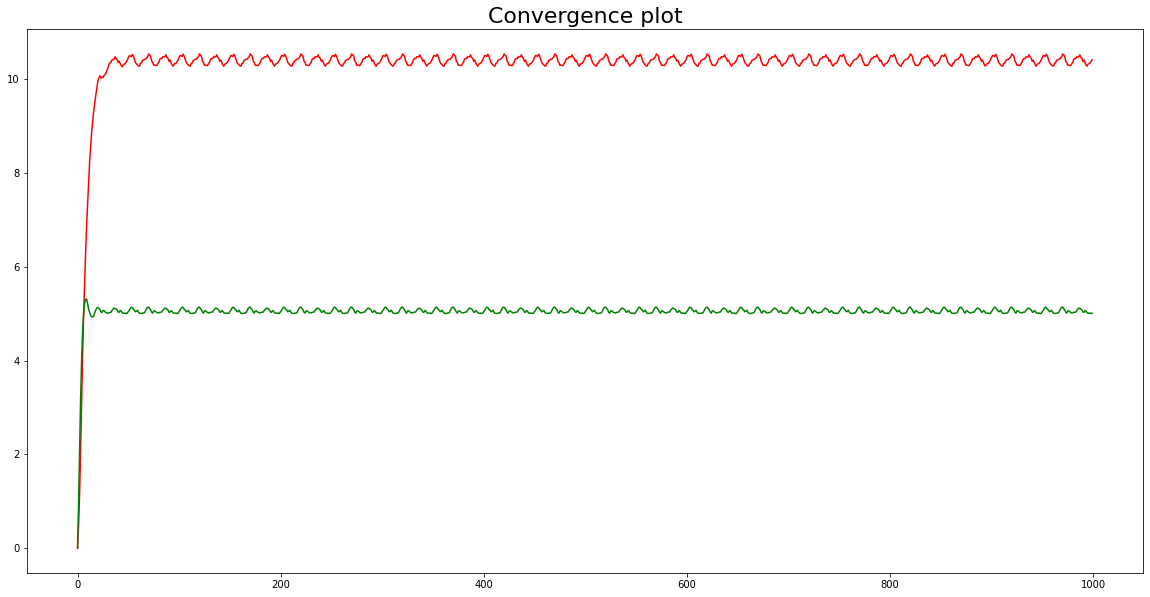

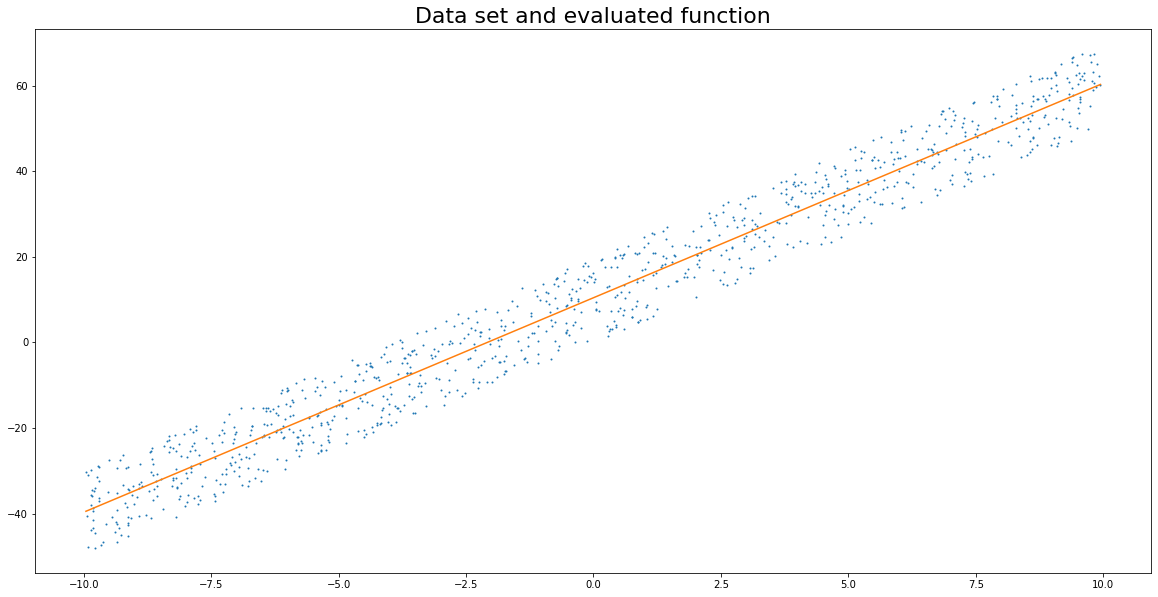

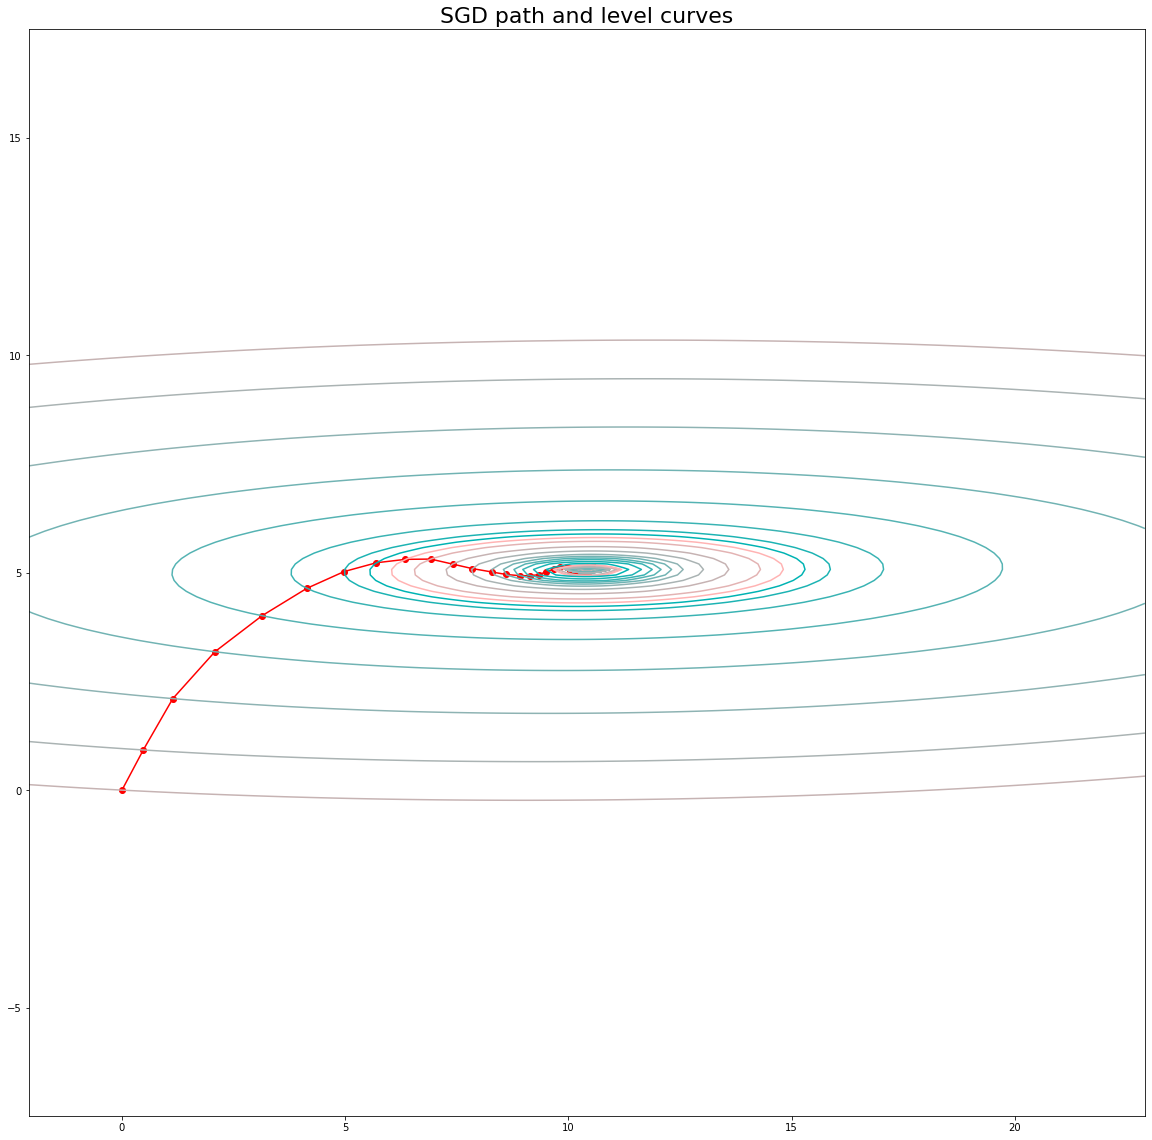

In [722]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
infinity_epoch = 1000
batch_size = 60
lr = [60, 5]
b = [0.5]
"""При попытке повысить точность momentum "перескакивает" через точку минимума"""
stop_criteria:Callable[[List[float]], bool]=lambda x: np.sum(np.abs(x - a)) < 0.05

start_time = time.time()
points = sgd_momentum(sum_fun, x, infinity_epoch, batch_size, lr, b, stop_criteria=stop_criteria)
print(f'Process time: {(time.time() - start_time) / len(points)}')

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Нагрузочное тестирование SGD_AdaGrad

Process time: 0.0041847083626723874
Precision: [0.01220052 0.03707272]
Min point: [9.98779948 4.96292728]
Iterations: 82
Path: [[ 0.          0.        ]
 [16.66666619 16.66666665]
 [ 1.14327082  1.87612025]
 [ 8.59503484  5.8494939 ]
 [10.14305088  5.07830889]
 [10.81640694  5.04974473]
 [10.5064436   4.88965238]
 [10.8483761   4.88922693]
 [10.47273238  4.80179133]
 [11.31550342  5.00915037]
 [ 8.37288633  5.14989928]
 [ 8.78811943  4.7249312 ]
 [ 9.8561322   4.90605026]
 [11.28404288  5.06098358]
 [ 9.90228416  4.89113951]
 [11.28323129  4.91936712]
 [10.41214235  4.9264034 ]
 [ 9.71411857  5.07182598]
 [ 9.62088694  4.91954466]
 [10.27376395  5.05863434]
 [ 9.53709313  4.99279252]
 [ 9.6694129   5.20634749]
 [10.43492951  4.95141109]
 [10.83833098  4.82453431]
 [10.97546555  4.97400299]
 [11.04133015  4.77081347]
 [ 9.30773908  5.1873124 ]
 [ 8.66305936  4.71103095]
 [ 9.36999692  4.99642404]
 [ 9.78438374  4.75342007]
 [11.36838294  5.06891343]
 [ 9.89769767  4.96663116]
 [11.3608

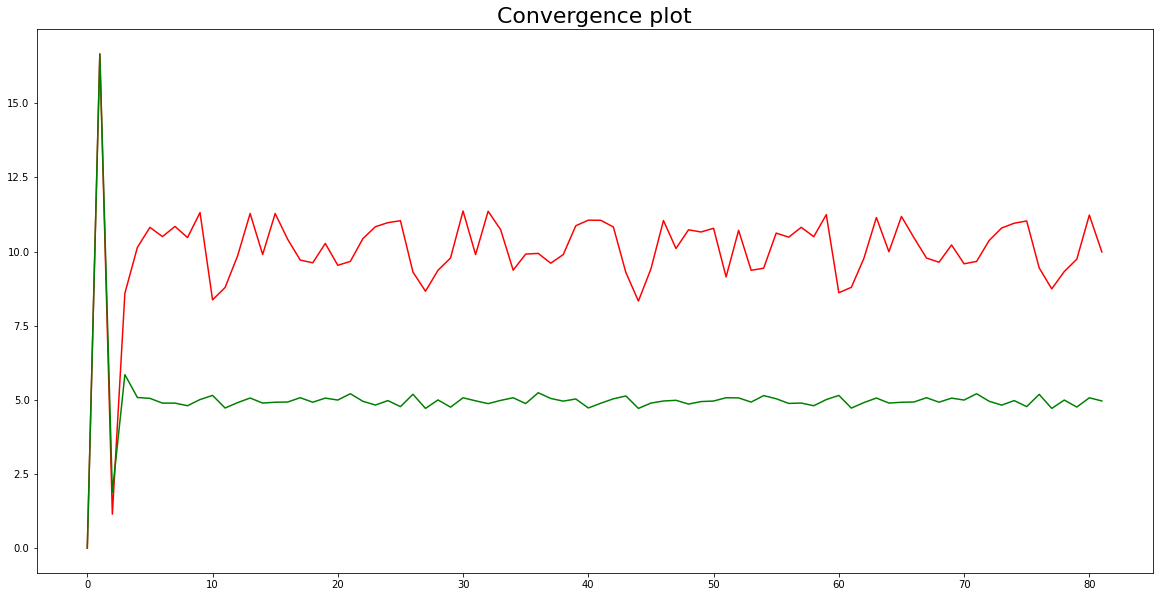

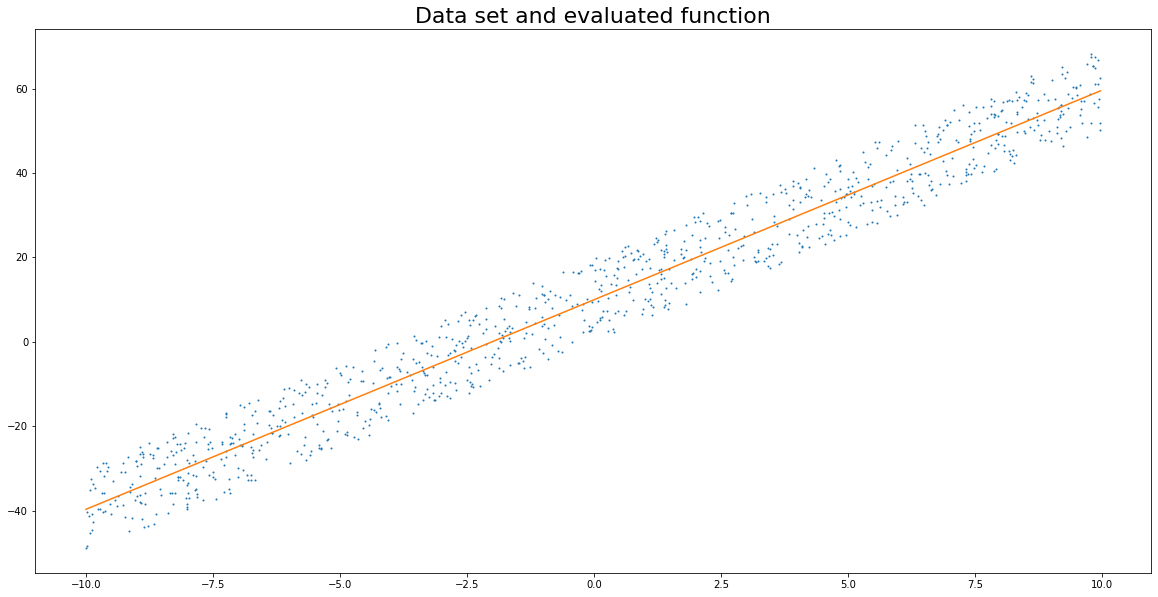

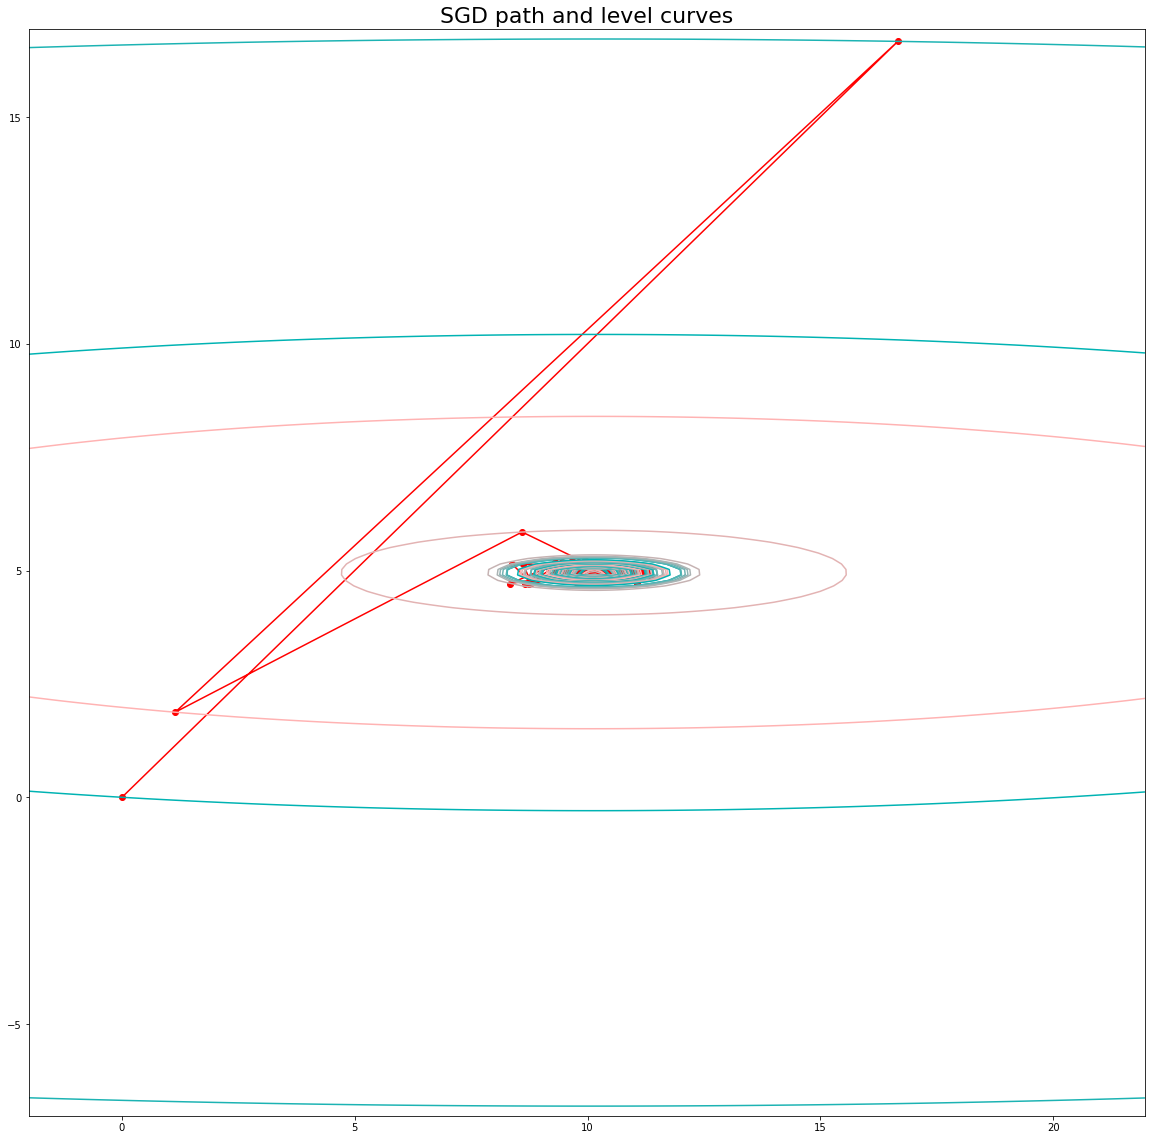

In [723]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
infinity_epoch = 1000
batch_size = 60
lr = 1000
"""
Удалось повысить точность в 5 раз, количество итераций как у Нестерова, но понижение в 10 раз влекло те же последствия, что и Momentum:
по второй координате заваливались по другую сторону числовой оси
upd: повышение точности оказалось ненадежным: успешен 1 прогон из 5
"""
stop_criteria:Callable[[List[float]], bool]=lambda x: np.sum(np.abs(x - a)) < 0.05

start_time = time.time()
points = sgd_adagrad(sum_fun, x, infinity_epoch, batch_size, lr, stop_criteria=stop_criteria)
print(f'Process time: {(time.time() - start_time) / len(points)}')

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Нагрузочное тестирование SGD_RMSProp

Process time: 0.004076819896697998
Precision: [0.37097417 0.17680931]
Min point: [9.62902583 4.82319069]
Iterations: 1000
Path: [[ 0.          0.        ]
 [ 3.16227752  3.16227765]
 [ 4.27241067  4.25357438]
 ...
 [10.00423246  5.29686053]
 [10.30880668  5.04801048]
 [ 9.62902583  4.82319069]]


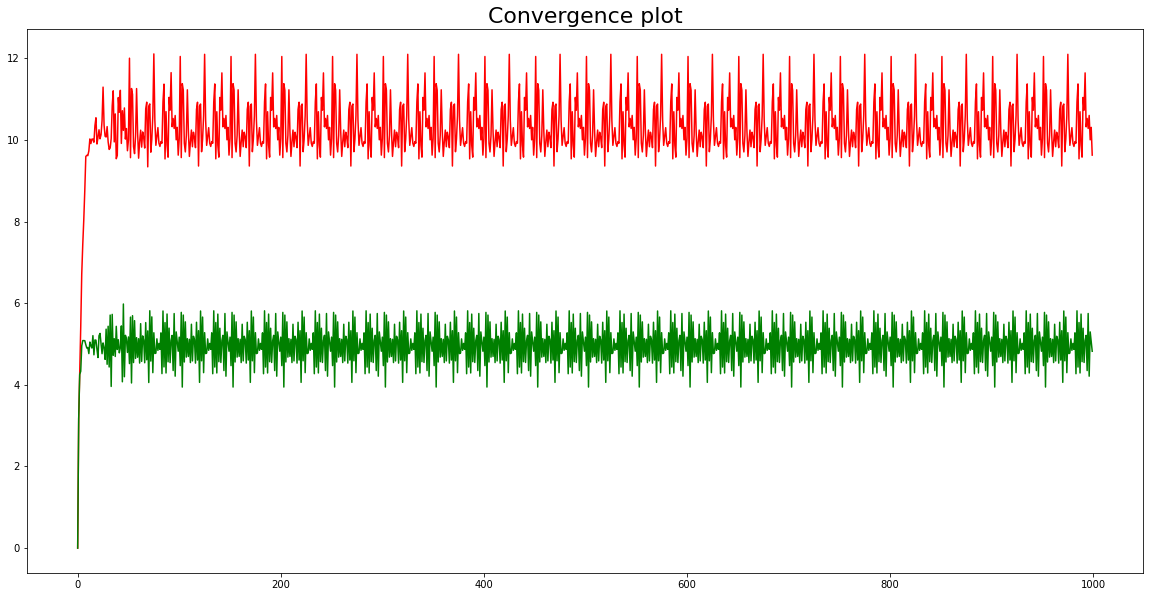

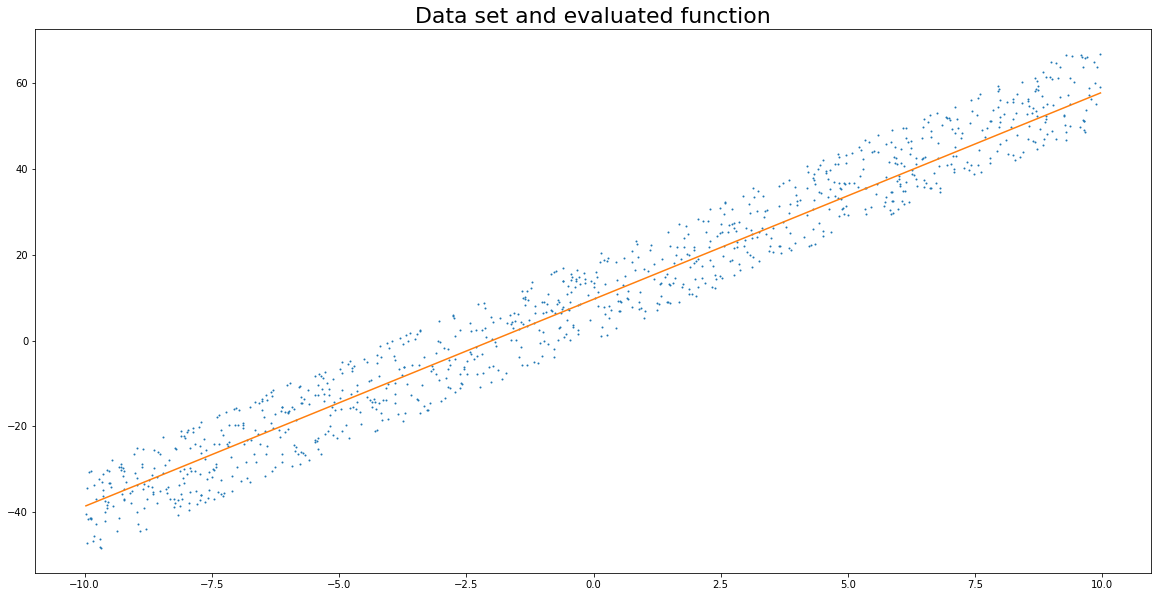

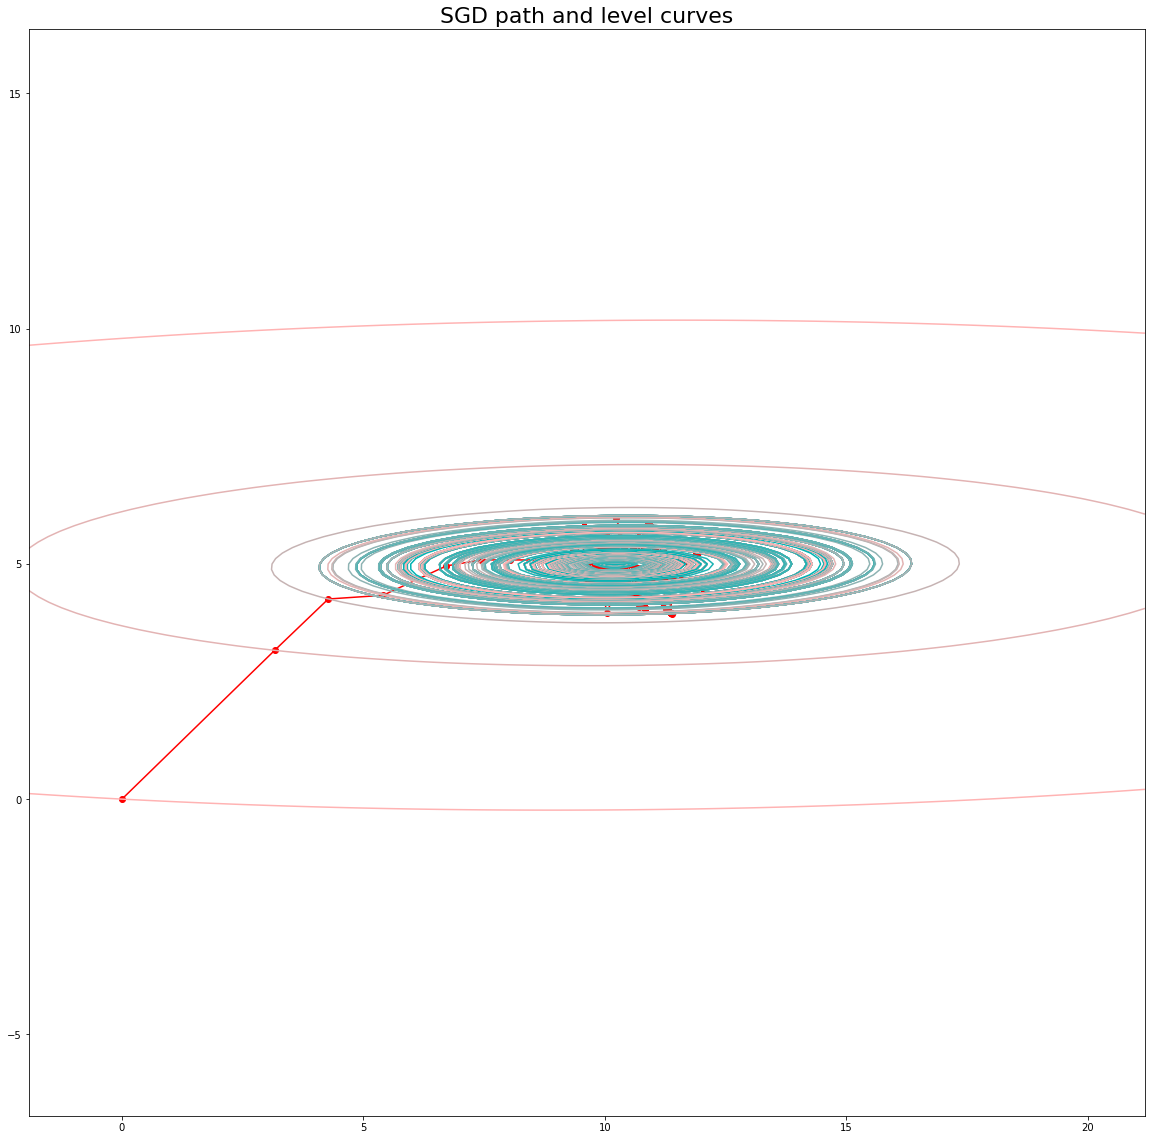

In [724]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
infinity_epoch = 1000
batch_size = 60
lr = 60
b = 0.9
"""Попытки повысить точность не увенчались успехом"""
stop_criteria:Callable[[List[float]], bool]=lambda x: np.sum(np.abs(x - a)) < 0.05

start_time = time.time()
points = sgd_rmsprop(sum_fun, x, infinity_epoch, batch_size, lr, b, stop_criteria=stop_criteria)
print(f'Process time: {(time.time() - start_time) / len(points)}')

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Нагрузочное тестирование SGD_Adam

Process time: 0.004203010559082032
Precision: [-0.07805058  0.29669885]
Min point: [10.07805058  4.70330115]
Iterations: 1000
Path: [[ 0.          0.        ]
 [ 0.95122941  0.95122942]
 [ 1.76536341  1.76989631]
 ...
 [10.38833955  5.26213357]
 [10.70464863  4.76653419]
 [10.07805058  4.70330115]]


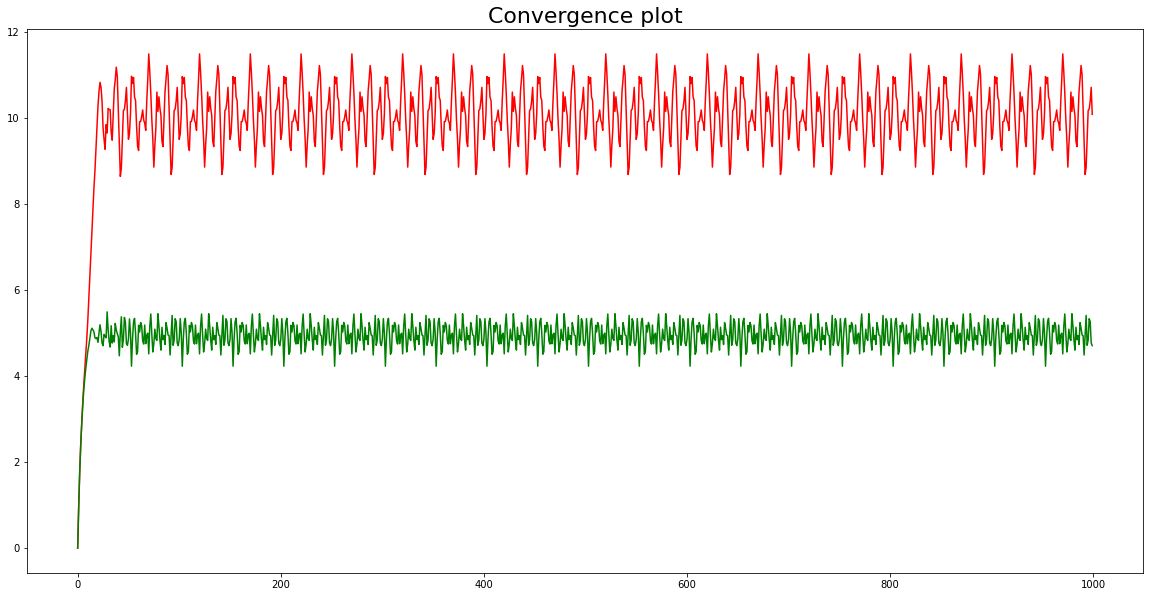

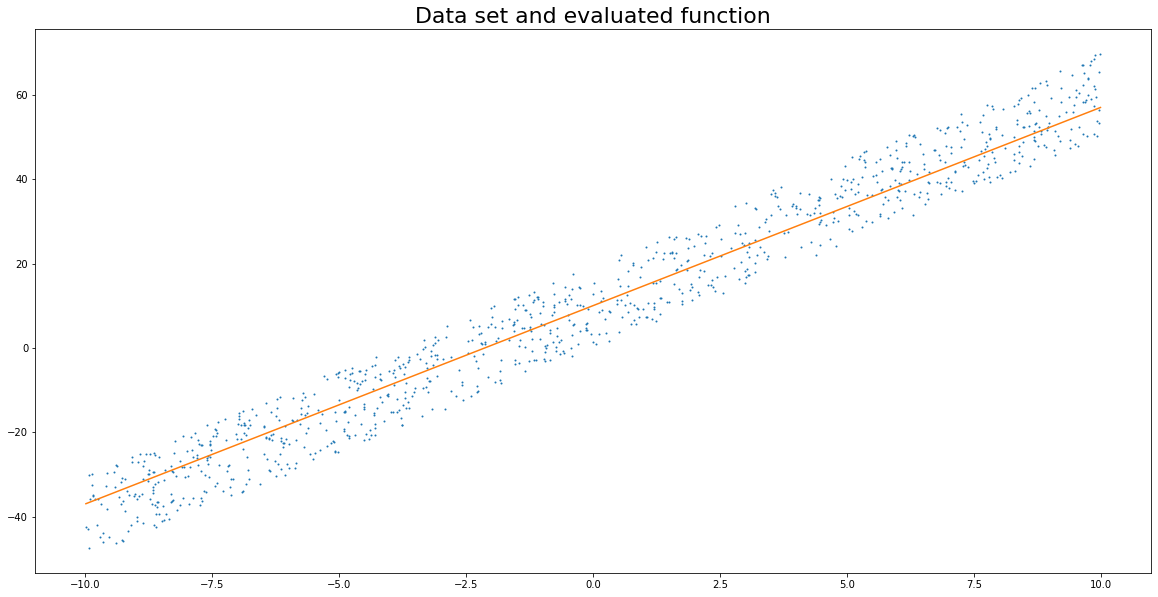

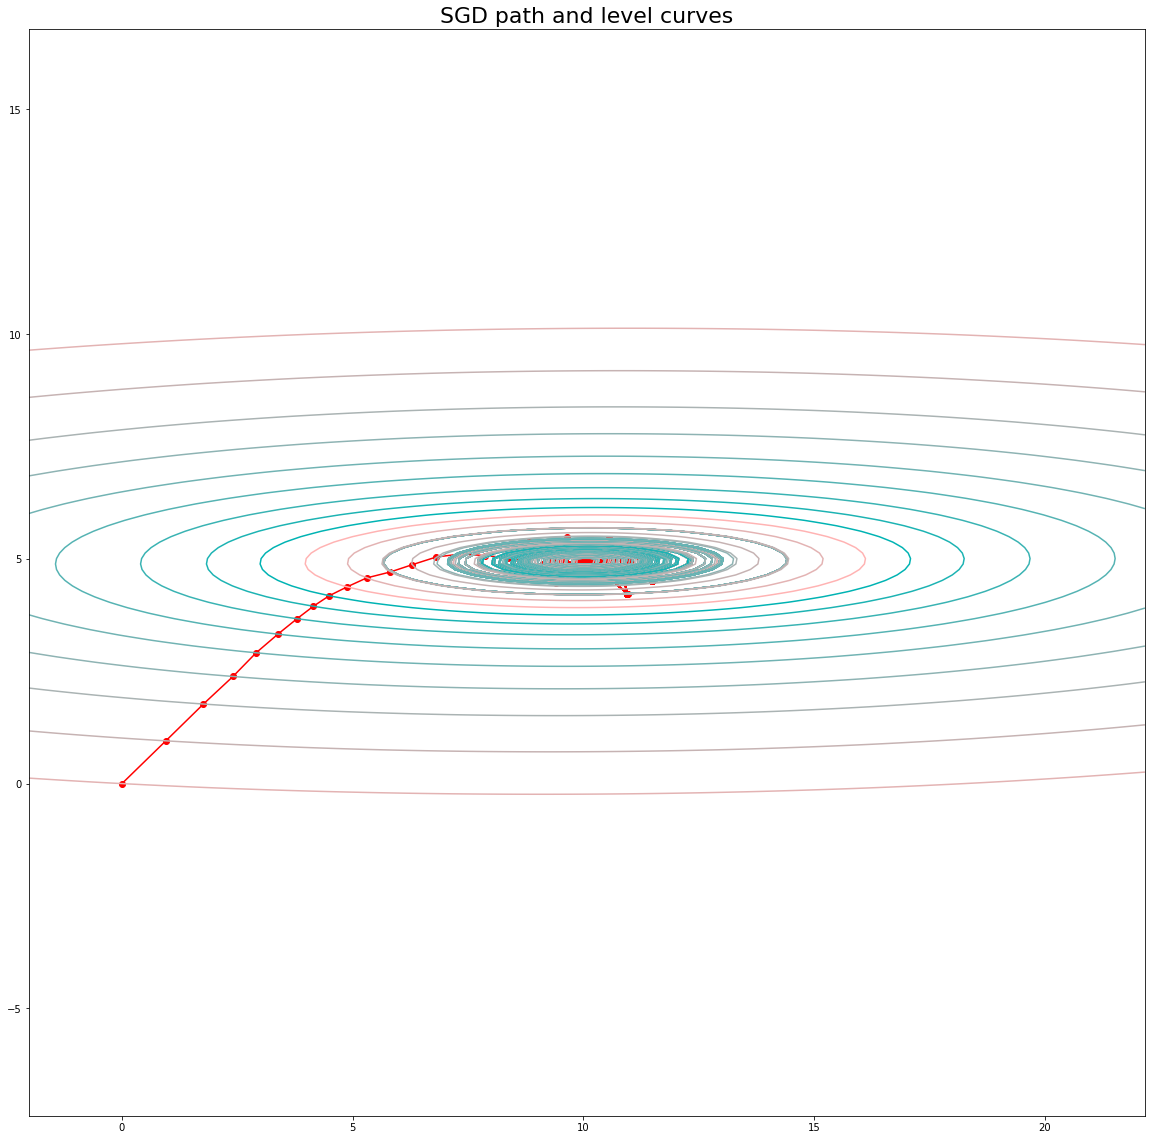

In [725]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
infinity_epoch = 1000
batch_size = 60
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)
"""
Повысить точность так же не удалось, но Adam показывает наилучшую надежность: 7 из 10 запусков были удачны и достигли
желаемой точности за 10-200 итераций
"""
stop_criteria:Callable[[List[float]], bool]=lambda x: np.sum(np.abs(x - a)) < 0.05

start_time = time.time()
points = sgd_adam(sum_fun, x, infinity_epoch, batch_size, lr, b1, b2, scheduler=scheduler, stop_criteria=stop_criteria)
"""
0.03123021125793457
1.8599903583526611
"""
print(f'Process time: {(time.time() - start_time) / len(points)}')

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

# Результаты и анализ нагрузочных тестов
## Время выполнения одной итерации алгоритмами:
Nesterov: 1.6084521788824318 ms<br>
Momentum: 1.6133334135627009 ms<br>
AdaGrad:  1.8321524513053467 ms<br>
RMSProp:  1.8016457349168367 ms<br>
Adam:     1.8647285017406509 ms

## Использование памяти:
Nesterov, Momentum, AdaGrad, RMSProp хранят одно дополнительное значение. Adam хранит два дополнительных значения. Созданные реализации сохраняют
данную корреляцию (все дополнительыне вычисляемые значения обернуты в листы из одного элемента).<br> Таким образом, все алгоритмы требуют больше RAM, чем обычный
градиентный спуск, при этом Adam расходует больше всего оперативной памяти.

## Арифметические операции:
Nesterov и Momentum требуют дополнительную операцию умножения на дополнительное значение (b).<br> AdaGrad возводит дополнительное значение в квадрат и делит.<br>RMSProp возводит в квадрат и умножает. <br>Adam включает в себя Momentum и RMSProp, и поэтому требует больше всего арифметических операций.

## Надежность
Ни один из алгоритмов не обладает абсолютной точностью. <br>Больше всего выделяется алгоритм Нестерова: примерно 1 из 10 запусков заканчивается сходимостью).
В среднем, алгоритмы успешно выполняют работу в 1 из 5 наборов сгенерированных датасетов

## Скорость сходимости
Худший результат: Nesterov: 500-700 итераций до достижения заявленной погрешности. <br>
Остальные алгоритмы могут показать  результат: < 100 итераций. <br>
В некоторых случаях Momentum, AdaGrad, RMSProp сходятся за 300-500 итераций. <br>
Выделяетсся алгоритм Adam: число итераций до достижения погрешности с этим алгоритмом стабильно в пределах от 10 до 200.

## Вывод
Наименее предпочтительный алгоритм - Nesterov, так как не отличается ни надежностью, ни скоростью при потреблении ресурсов (количество арифметических операций и затраченной RAM) сопоставим с Momentum, AdaGrad и RMSProp. <br>Наилучший результат показывает Adam, так как совмещает в себе два алгоритма Momentum и RMSProp.Увеличение производительности и надежности в сравнении с увеличением затрачиваемых ресурсов выгодно на фоне остальных алгоритмов.